# PART I: Theory Questions

## Question 1-2) 
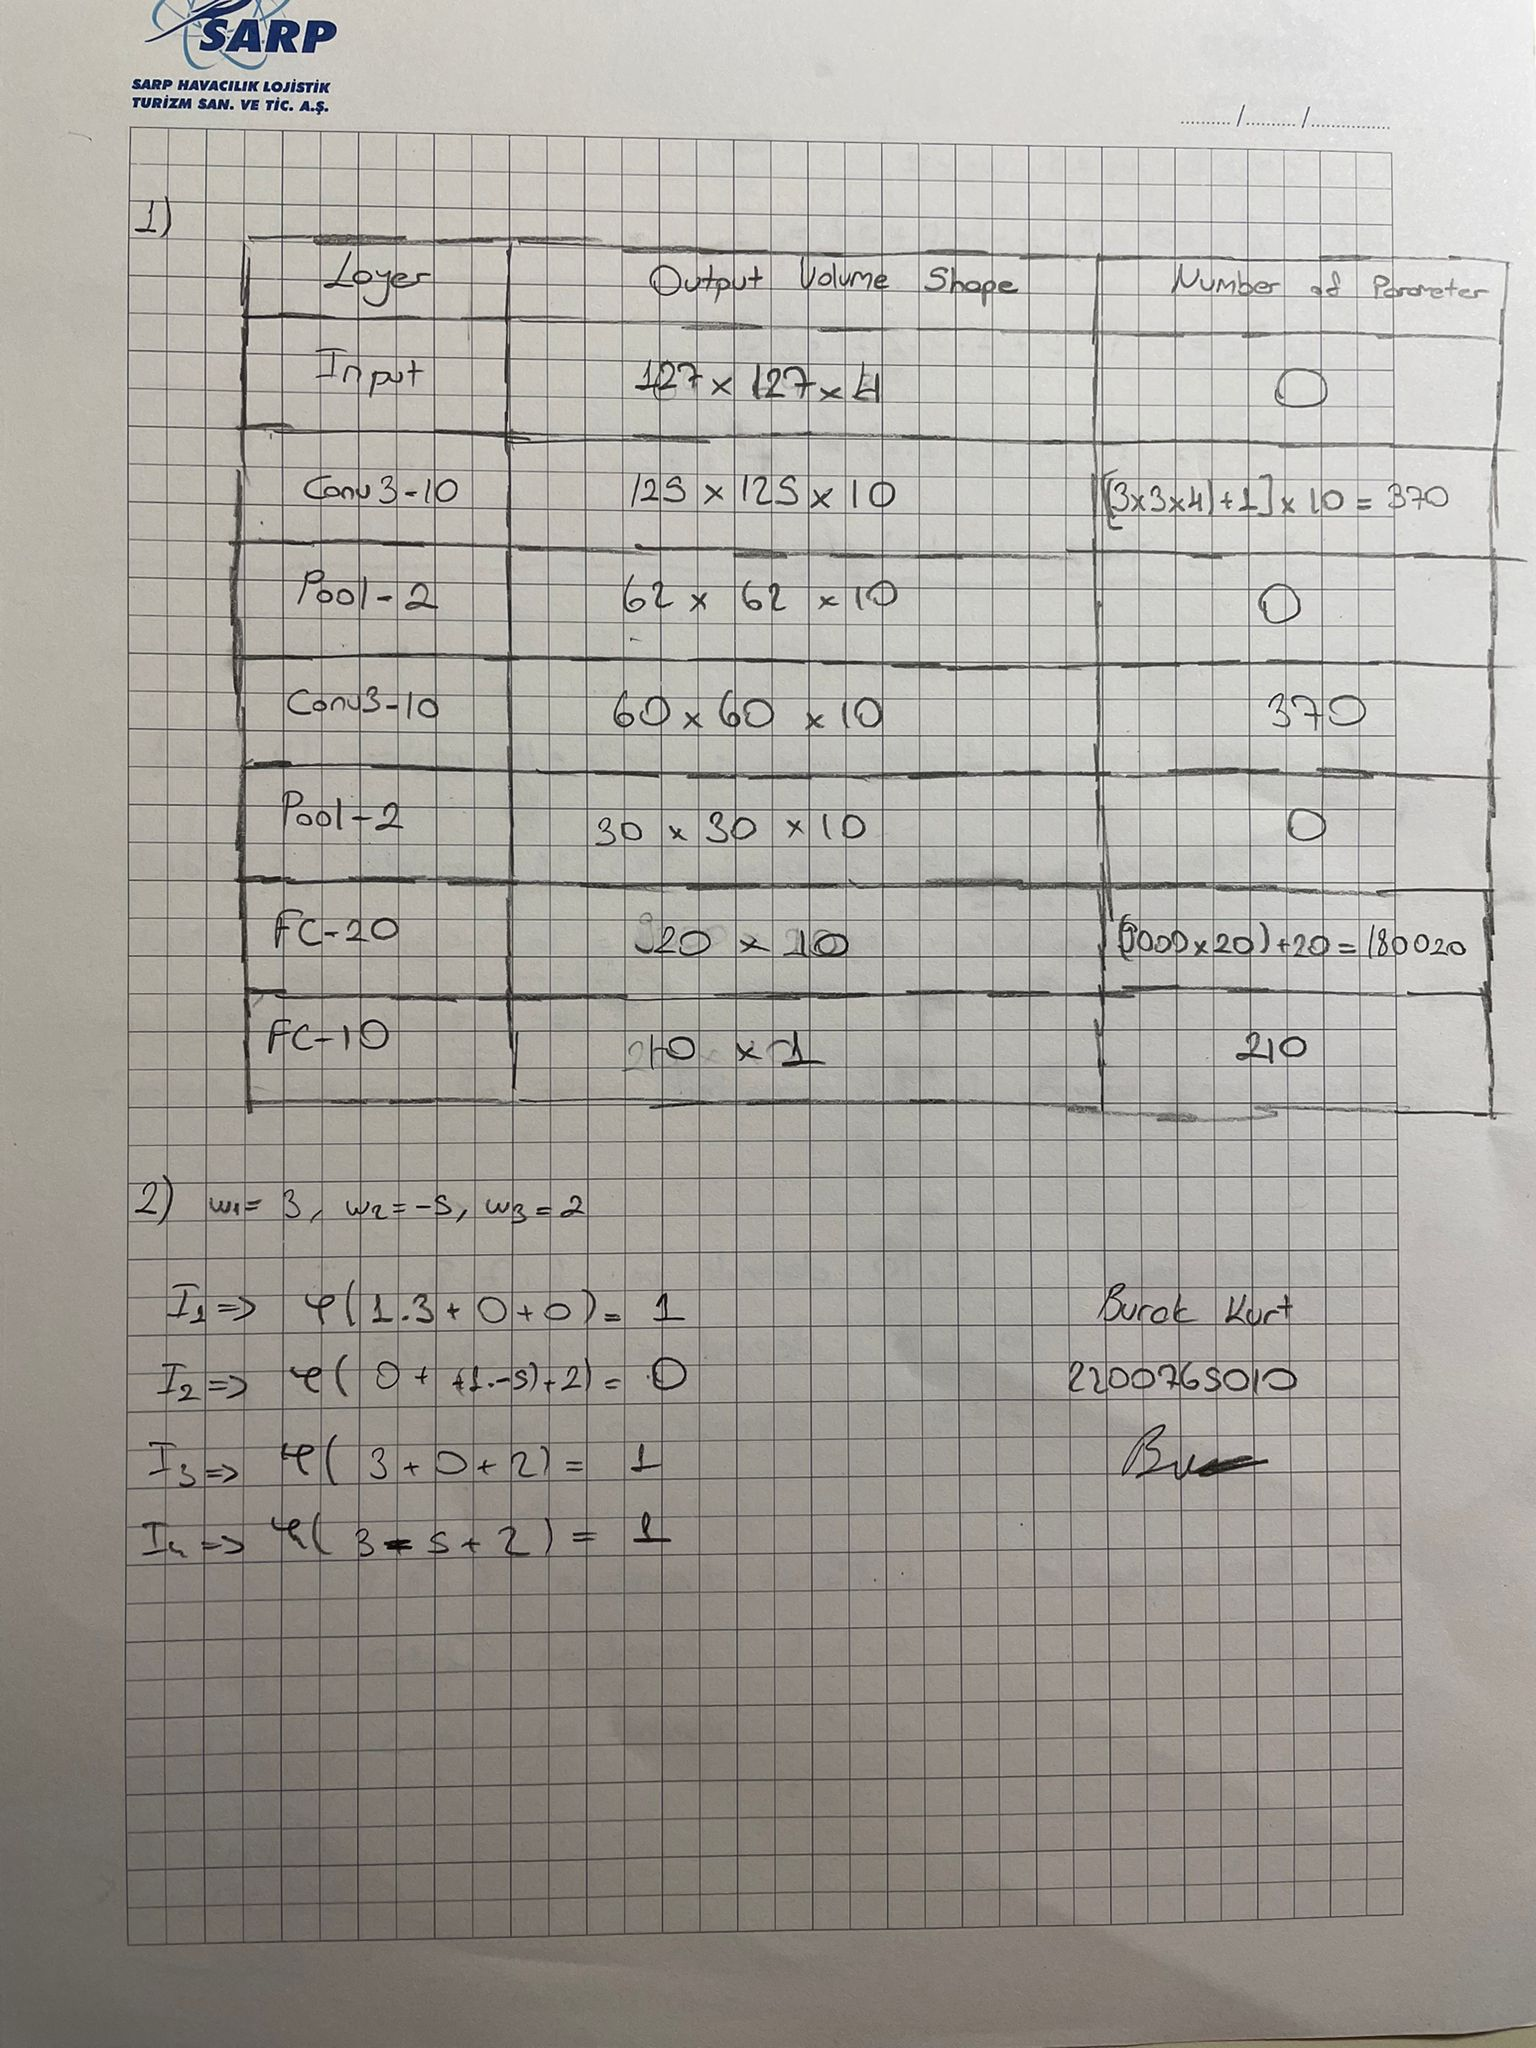

## Question 3)
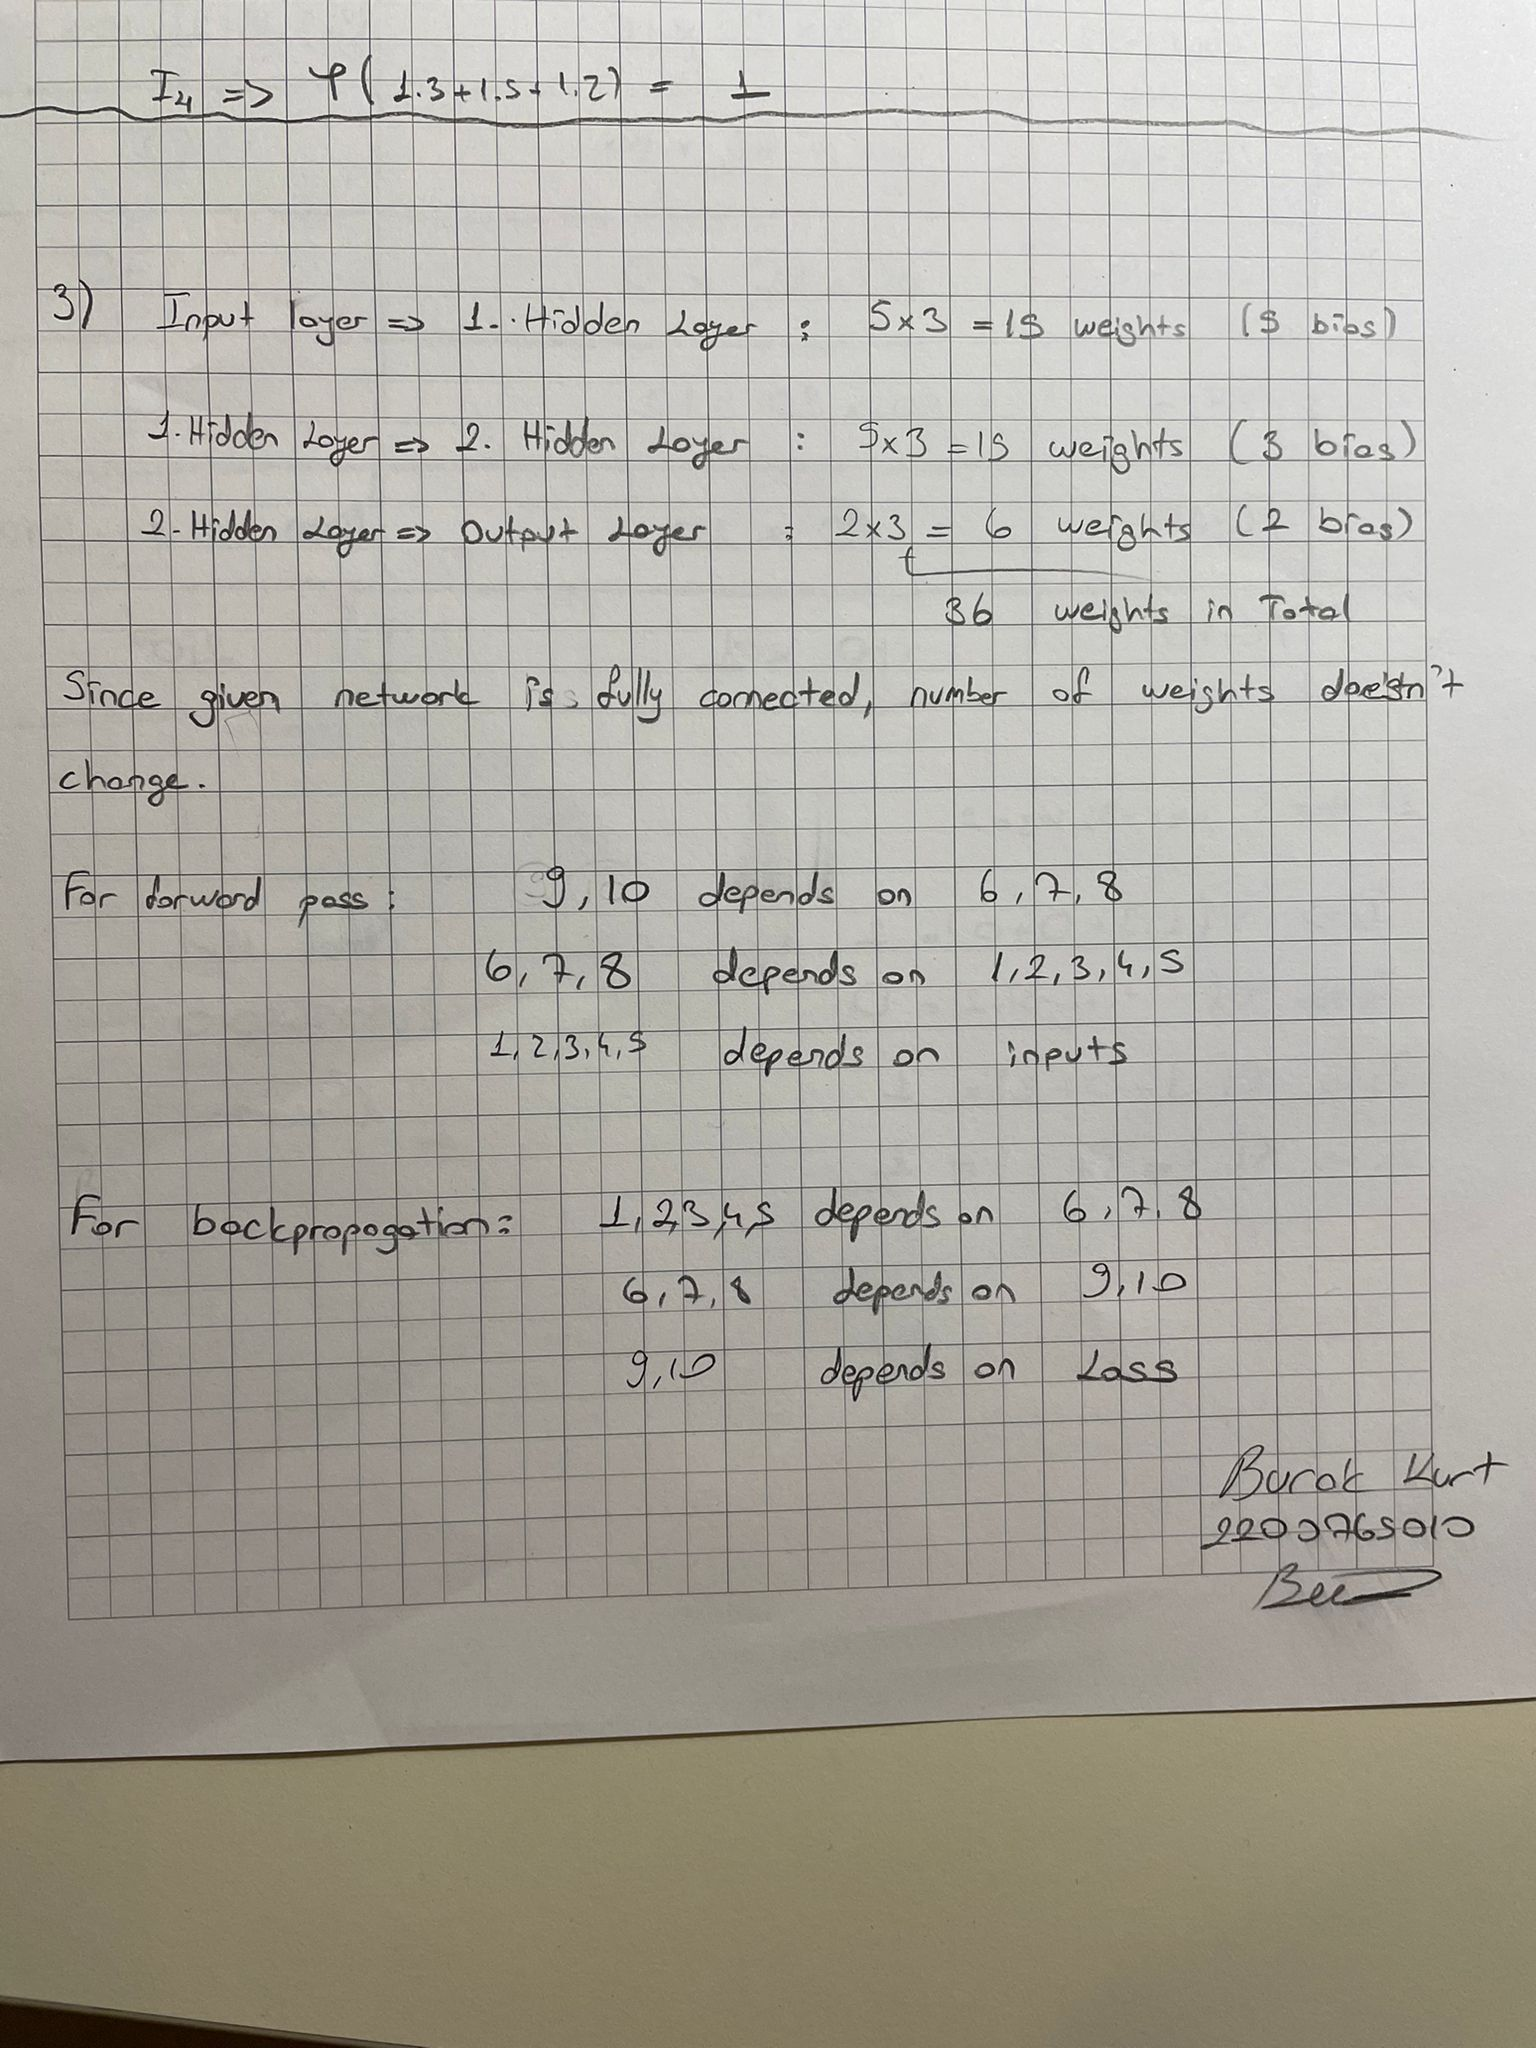

# PART II: Classification of Mel Spectrogram images using Neural Network

In [2]:
import pandas as pd
import os
import numpy as np
import cv2
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import torch

In [3]:
traindf = pd.read_csv("voice_dataset/train_data.csv")
testdf = pd.read_csv("voice_dataset/test_data.csv")

traindf = traindf.sample(frac=1).reset_index(drop=True)
testdf = testdf.sample(frac=1).reset_index(drop=True)

In [4]:
cols = ["text","gender","accent"]

traindf.drop(cols, axis=1, inplace=True)
testdf.drop(cols, axis=1, inplace=True)

In [5]:

file_names_train = traindf["filename"].values
file_names_test = testdf["filename"].values
ohe = OneHotEncoder()
train_y = traindf["age"].values
test_y = testdf["age"].values

train_y = ohe.fit_transform(train_y.reshape(-1,1)).toarray()

test_y = ohe.fit_transform(test_y.reshape(-1,1)).toarray()


In [6]:
def readImages(file_names, path):
    img_list = []
    for i in range(len(file_names)):
        fullpath = path + file_names[i]
    
        img = cv2.imread(fullpath, 0)
        img = cv2.resize(img, (32,32))
        
        img_list.append(img)

    return np.array(img_list)

def FlattenImages(img_list):
    flat_list = []
    for i in range(len(img_list)):
        img_flat = img_list[i].flatten().astype(float)
        
        img_flat /= 255
        flat_list.append(img_flat)
    return np.array(flat_list)


In [7]:
train_img = readImages(file_names_train,"voice_dataset/train/")
test_img = readImages(file_names_test,"voice_dataset/test/")

In [8]:
train_flatten = FlattenImages(train_img)
test_flatten = FlattenImages(test_img)



In [13]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation = activation
        
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases for hidden layers
        prev_size = input_size
        for size in hidden_sizes:
            weight = np.random.randn(size, prev_size)
            bias = np.zeros((size, 1))
            self.weights.append(weight)
            self.biases.append(bias)
            prev_size = size
        
        # Initialize weights and biases for output layer
        weight = np.random.randn(output_size, prev_size)
        bias = np.zeros((output_size, 1))
        self.weights.append(weight)
        self.biases.append(bias)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)
    
    def _leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def _softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0))
        return exps / np.sum(exps, axis=0)
    
    def _softmax_derivative(self, x):
        softmax = self._softmax(x)
        return softmax * (1 - softmax)
    
    def _forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights)):



            Z = np.dot(self.weights[i], activations[i]) + self.biases[i]

            if (i == len(self.weights)-1):
                
                A = self._softmax(Z)
                activations.append(A)
                break

            if self.activation == 'sigmoid':
                A = self._sigmoid(Z)
            elif self.activation == 'relu':
                A = self._leaky_relu(Z)
            activations.append(A)

        return activations
    
    def _compute_loss(self, Y, Y_hat):
        m = Y.shape[1]
        loss = -np.sum(Y * np.log(Y_hat+1e-8)) / m
        return loss
    
    def _backward_propagation(self, X, Y, activations):
        m = X.shape[1]
        grads = []
        
        dA = activations[-1] - Y
        dW = np.dot(dA, activations[-2].T) / m
        db = np.sum(dA, axis=1, keepdims=True) / m
        grads.append((dW, db))
        
        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(self.weights[i + 1].T, dA)
            if self.activation == 'sigmoid':
                dZ = dA * activations[i + 1] * (1 - activations[i + 1])
            elif self.activation == 'relu':
                dZ = dA * self._leaky_relu_derivative(activations[i + 1])
            dW = np.dot(dZ, activations[i].T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            grads.append((dW, db))
        
        return grads[::-1]
    
    def train(self, X, Y,test_X,test_Y, learning_rate, epochs, batch_size):
        m = X.shape[1]
        num_batches = m // batch_size
        epoch_loss= []
        epoch_test_loss = []
        for epoch in range(1,epochs+1):
            batch_losses = []
            batch_test_losses = []
            for batch in range(num_batches):
                start = batch * batch_size
                end = start + batch_size
                X_batch = X[:, start:end]
                Y_batch = Y[:, start:end]
                
                activations = self._forward_propagation(X_batch)
                grads = self._backward_propagation(X_batch, Y_batch, activations)

                batch_losses.append(self._compute_loss(Y_batch, activations[-1]))   
                batch_test_losses.append(self._compute_loss(test_Y, self._forward_propagation(test_X)[-1]))


                for i in range(len(self.weights)):
                    self.weights[i] -= learning_rate * grads[i][0]
                    self.biases[i] -= learning_rate * grads[i][1]
            
            epoch_loss.append(np.array(batch_losses).mean())
            epoch_test_loss.append(np.array(batch_test_losses).mean())
            if(epoch%10==0):
                print(f'Epoch {epoch}/{epochs} loss: {epoch_loss[-1]}, test_loss: {epoch_test_loss[-1]}')
        return epoch_loss,epoch_test_loss


    def predict(self, X):
        activations = self._forward_propagation(X)
        Y_hat = activations[-1]
        return np.argmax(Y_hat, axis=0)
    
    def TestLoss(self, X, Y):
        return self._compute_loss(Y, self._forward_propagation(X)[-1])
    
    def visualize_weights(self):
        for i in range(len(self.weights)):
            plt.figure(figsize=(20, 8))
            plt.imshow(self.weights[i], cmap='gray')
            plt.show()


    def accuracy(self, X, Y):
        Y_hat = self.predict(X)
        return (Y_hat == Y).mean()


In [9]:
def CNNModel(kernel_Num,activation,hidden_sizes):
    if activation == 'sigmoid':
        activation = torch.nn.Sigmoid()
    elif activation == 'relu':
        activation = torch.nn.ReLU()
    
    model = torch.nn.Sequential()


    for i in range(len(kernel_Num)):
        if i == 0:
            model.add_module("conv1",torch.nn.Conv2d(1, 24, kernel_size=3, stride=1, padding=0))
            model.add_module("act1",activation)
        else:
            model.add_module("conv2",torch.nn.Conv2d(24,8 , kernel_size=3, stride=1, padding=0))
            model.add_module("act2",activation)

    model.add_module("pool",torch.nn.MaxPool2d(kernel_size=2, stride=4))
    model.add_module("flatten",torch.nn.Flatten())

    for j in range(len(hidden_sizes)):
        if (j == 0):
            if(len(kernel_Num) == 1):
                model.add_module("lin1",torch.nn.Linear(24*8*8, hidden_sizes[j]))
            else:
                model.add_module("lin2",torch.nn.Linear(8*8*8, hidden_sizes[j]))

            model.add_module("act3",activation)
        else:
            model.add_module("lin3",torch.nn.Linear(hidden_sizes[j-1], hidden_sizes[j]))
            model.add_module("act4",activation)

    model.add_module("lin5",torch.nn.Linear(hidden_sizes[-1], 6))
    model.add_module("softmax",torch.nn.Softmax())

    return model

In [10]:
def experiment_MLP(experiment,loss_list):
    
    activation = experiment[0]
    hidden_sizes = experiment[1]
    learning_rate = experiment[2]
    epochs = experiment[3]
    batch_size = experiment[4]
    input_size = experiment[5]
    output_size = experiment[6]

    nn = NeuralNetwork(input_size, hidden_sizes, output_size, activation)
    loss,test_loss = nn.train(train_flatten.T, train_y.T,test_flatten.T,test_y.T, learning_rate, epochs, batch_size)
    plt.plot(loss,label="Train Loss")
    plt.plot(test_loss,label="Test Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    test_loss = nn.TestLoss(test_flatten.T, test_y.T)
    print("Test Loss: ",test_loss)
    print("Test Accuracy: ",nn.accuracy(test_flatten.T, np.argmax(test_y.T, axis=0)))
    loss_list.append(test_loss)

In [11]:
def experiment_CNN(experiment):
    activation = experiment[0]
    hidden_sizes = experiment[1]
    learning_rate = experiment[2]
    epochs = experiment[4]
    batch_size = experiment[3]
    kernel_Num = experiment[5]

    cnn = CNNModel(kernel_Num,activation,hidden_sizes)
    optimizer = torch.optim.AdamW(cnn.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()
    epoch_losses = []
    test_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(train_img), batch_size):
            batch_X = train_img[i:i+batch_size].reshape(-1, 1, 32, 32)
            
            batch_y = train_y[i:i+batch_size]

            X = torch.autograd.Variable(torch.Tensor(batch_X))
            y = torch.autograd.Variable(torch.Tensor(batch_y), requires_grad=False)
            
            
            
            y_pred = cnn(X)
            loss = loss_fn(y_pred, torch.max(y, 1)[1])
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if(epoch%10==0):
            print(f'Epoch {epoch}/{epochs} loss: {loss.item()}')

        epoch_losses.append(epoch_loss / (len(train_img) / batch_size))
        test_X = test_img.reshape(-1, 1, 32, 32)
        X = torch.autograd.Variable(torch.Tensor(test_X))
        y = torch.autograd.Variable(torch.Tensor(test_y), requires_grad=False)
        y_pred = cnn(X)
        test_loss = loss_fn(y_pred, torch.max(y, 1)[1])
        test_losses.append(test_loss.item())

    plt.plot(epoch_losses,label="Train Loss")
    plt.plot(test_losses,label="Test Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    test_x  = test_img.reshape(-1, 1, 32, 32)
    X = torch.autograd.Variable(torch.Tensor(test_x))
    y = torch.autograd.Variable(torch.Tensor(test_y), requires_grad=False)
    y_pred = cnn(X)
    accuracy = (torch.max(y_pred, 1)[1] == torch.max(y, 1)[1]).sum().item() / len(test_y)
    print("Accuracy: ",accuracy)

 

    #test_loss = cnn.evaluate(test_img,test_y)
    #print("Test Loss: ",test_loss)
    #print("Test Accuracy: ",cnn.accuracy(test_img, np.argmax(test_y, axis=1)))

## Weight Visualization

Epoch 10/100 loss: 1.9278039673074052, test_loss: 1.9564966484097037
Epoch 20/100 loss: 1.8182040283112375, test_loss: 1.8625941720080474
Epoch 30/100 loss: 1.776719184857587, test_loss: 1.842166990371703
Epoch 40/100 loss: 1.7515981992140057, test_loss: 1.8278223291061833
Epoch 50/100 loss: 1.7260976317508676, test_loss: 1.8155339950273015
Epoch 60/100 loss: 1.701420870795699, test_loss: 1.8021114948889434
Epoch 70/100 loss: 1.6817956156183058, test_loss: 1.795315597973544
Epoch 80/100 loss: 1.6669475910908629, test_loss: 1.7909450436018082
Epoch 90/100 loss: 1.6527710047929978, test_loss: 1.785958234049114
Epoch 100/100 loss: 1.644551234360881, test_loss: 1.7915627859941068


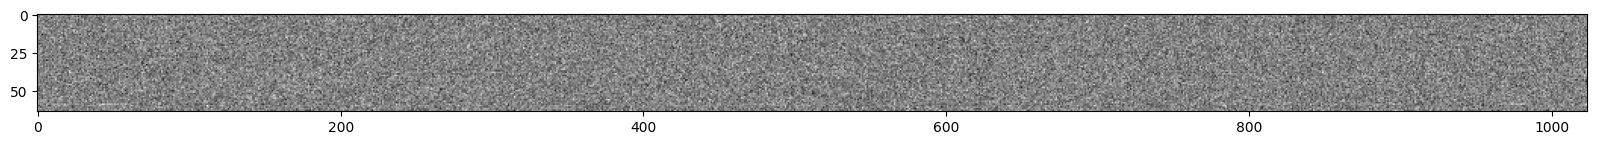

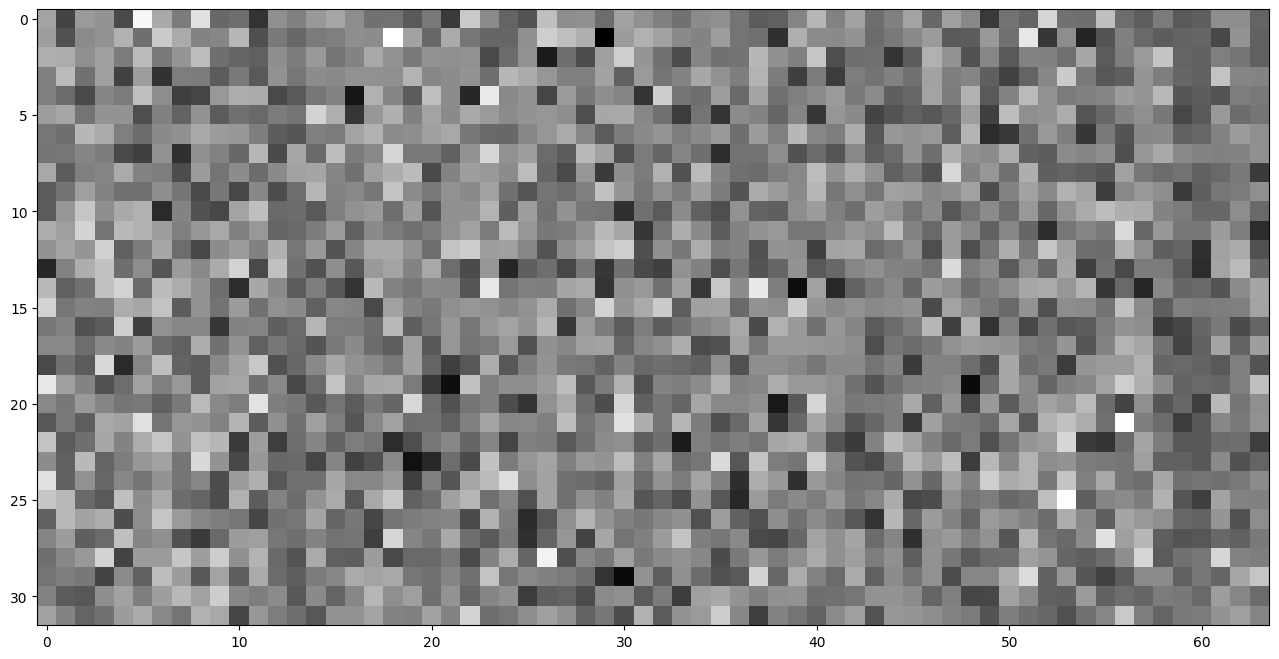

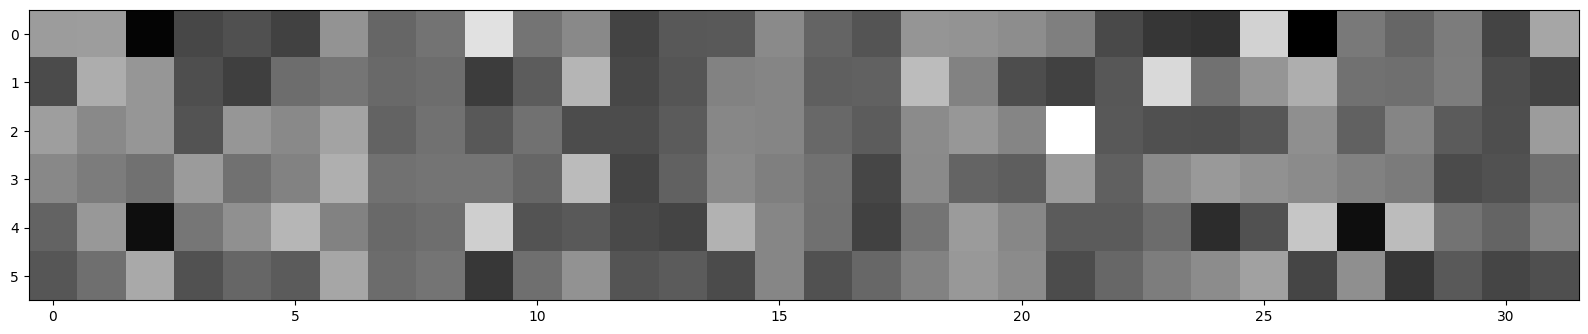

In [14]:
model = NeuralNetwork(32*32,[64,32],6,"relu")
model.train(train_flatten.T, train_y.T,test_flatten.T,test_y.T, 0.01, 100, 32)

model.visualize_weights()


## Note: Experiments take too much space so I decided to write report here. Each experiment can be seen under the report part.






# REPORT

## MLP with 2 Hidden Layers

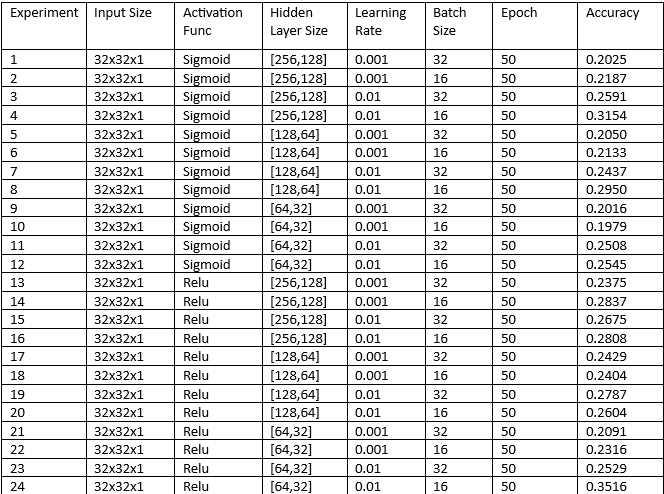

Learning rate: Comparing experiments 3 and 4, we can see that a higher learning rate (0.01 vs. 0.001) leads to a higher accuracy (0.3154 vs. 0.2591). However, this accuracy gain comes at the cost of a higher batch size (16 vs. 32), which can require more memory.

Hidden layer size: Comparing experiments 5 and 7, we can see that a larger hidden layer size (256, 128 vs. 128, 64) does not necessarily lead to a higher accuracy (0.2050 vs. 0.2437). This is likely because the model with the larger hidden layer size is overfitting the training data.

Activation function: Comparing experiments 13 and 14, we can see that the ReLU activation function outperforms the sigmoid activation function (0.2375 vs. 0.2025). This is consistent with the general trend that the ReLU activation function tends to lead to higher accuracies.

## MLP with 1 Hidden Layer

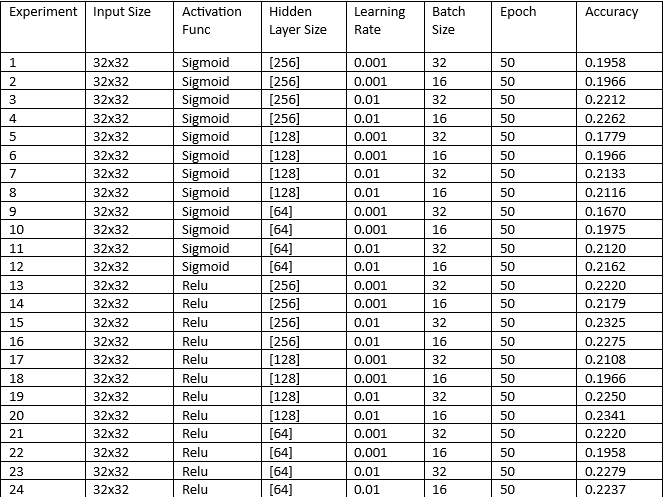

Hidden Layer Size: A larger hidden layer size seems to contribute to higher accuracy. This could be because a larger number of neurons can capture more complex patterns in the data.

Learning Rate: A smaller learning rate is associated with higher accuracy. This might indicate that the model benefits from making smaller updates to the weights, allowing for more precise adjustments during training.

Batch Size: A larger batch size appears to result in lower accuracy. This might suggest that using smaller batches allows the model to generalize better by updating weights more frequently.

## MLP with No Hidden Layer

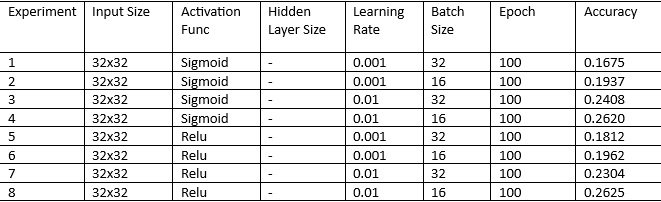

Learning Rate Impact: The experiments show different accuracies based on the learning rate. A lower learning rate of 0.001 resulted in an accuracy of 0.1675, while a higher learning rate of 0.01 led to a slightly better accuracy of 0.1937. This suggests that even without a hidden layer, the learning rate plays a significant role in the model’s performance.

Simpler Model: Without a hidden layer, the model is essentially a logistic regression classifier. This simpler model may not capture complex patterns as effectively as a multilayer perceptron, but it can still provide insights into the linear separability of the data.

Consistent Parameters: The input size, activation function, batch size, and epoch are consistent across experiments. This consistency helps isolate the effect of the learning rate on the model’s accuracy.

Accuracy Consideration: The accuracies are relatively low, which might be due to the absence of a hidden layer. It indicates that for the given dataset, a more complex model with at least one hidden layer might be necessary to achieve higher accuracy.

## CNN with 2 Convolutional Layers

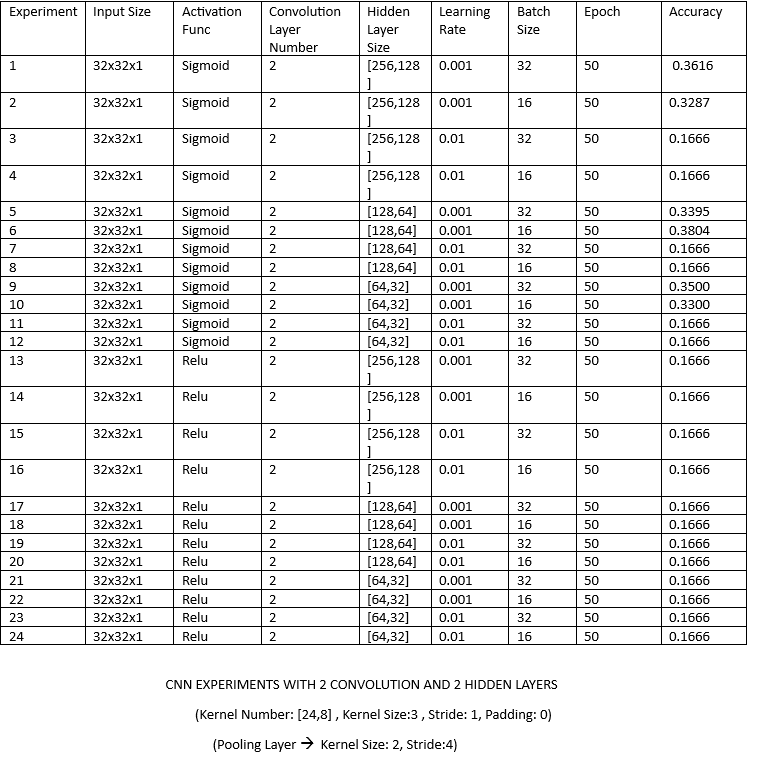

Learning Rate: The experiments show that a lower learning rate of 0.001 results in an accuracy of 0.3617, which is higher compared to the accuracy of 0.3286 with a learning rate of 0.01. This suggests that the CNN model benefits from a slower learning process, allowing for more nuanced adjustments to the weights.

Batch Size: The accuracy is higher with a smaller batch size of 16 compared to a larger batch size of 32. This could indicate that smaller batches provide a regularizing effect and help the model generalize better.

Model Architecture: With 2 convolution layers and 2 hidden layers, the model is able to learn more complex features from the data. The choice of activation function, kernel size, and other hyperparameters would also affect the model’s performance.

## CNN with 1 Convolutional Layer

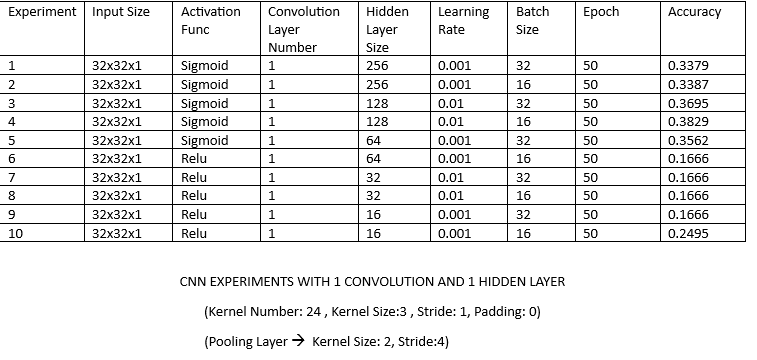

Number of Hidden Units: The number of hidden units has the greatest impact on model accuracy. Reducing the number of hidden units from 256 to 128 improves accuracy (from 33.79% to 38.29%). However, further reducing the number of hidden units to 64, 32, or 16 significantly harms accuracy (16.66% in all cases).

Batch Size: Increasing the batch size from 32 to 64 offers a modest improvement in accuracy (24.95% with 16 hidden units).

Learning Rate: The learning rate does not seem to have a significant impact on accuracy.

Activation Function: Changing the activation function from sigmoid to ReLU does not significantly affect accuracy.

## Analysis of MLP Models

Generalization: While the 2-layer setup achieved higher accuracies, it could also be prone to overfitting due to its higher complexity. Further analysis with validation sets and regularization techniques would be necessary to validate its generalization ability.

Computational cost: The 2-layer setup requires more training time and computational resources due to its higher number of parameters. This might be a concern for large datasets or computationally limited environments.

Interpretability: Networks with fewer layers are generally easier to interpret due to simpler decision boundaries. This could be an advantage in situations where understanding the model's reasoning is crucial.

The 2-layer neural network demonstrated the best performance in terms of accuracy. However, the choice of the optimal network architecture depends on various factors, including the complexity of the task, available resources, and the need for interpretability.

## Analysis of CNN Models

The CNN model with 2 convolutional and hidden layers outperforms the CNN model with 1 convolutional and hidden layer in terms of accuracy. This suggests that the additional convolutional layer in the 2-layer setup helps to learn more complex spatial features.

The CNN model with 1 convolutional and hidden layer can be a good choice for image classification tasks, but it may not achieve the same level of accuracy as the CNN model with 2 convolutional and hidden layers.

## MLP and CNN comparison

Overall Performance:

CNN models generally achieved higher accuracy than MLP models on the image classification task, demonstrating their superior capability in learning spatial features from image data.
The best performing CNN model with 2 convolutional and hidden layers achieved an accuracy of 0.3616, significantly exceeding the best performing MLP model with 2 hidden layers (0.3154).
Impact of Network Architecture:

Adding additional convolutional layers in the CNN architecture consistently improved performance, indicating the importance of extracting hierarchical features for complex tasks.
Increasing the number of hidden layers in the MLP model also led to modest improvements, but the benefit was not as significant as in the CNN model.
Activation Function and Batch Size Effects:

ReLU activation function generally outperformed the sigmoid activation function in both CNN and MLP models, suggesting its effectiveness in capturing non-linear relationships in the data.
Larger batch sizes (32) tended to lead to better results compared to smaller ones (16) in both models, potentially due to improved optimization during training.
Choice of Model:

CNN models are the preferred choice for image classification tasks due to their superior performance and ability to learn spatial features.
MLP models can be a good alternative for simpler tasks or when computational resources are limited, but their accuracy may be lower compared to CNNs.

# Experiment Setups

## 2 Hidden Layer

In [ ]:
input_size = 32*32
output_size = 6
activation = ["sigmoid","relu"]
hidden_size = [[256,128],[128,64],[64,32]]
learning_rate = [0.01,0.001]
batch_size = [32,16]
epoch = 50

ex1 = [activation[0],hidden_size[0],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex2 = [activation[0],hidden_size[0],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex3 = [activation[0],hidden_size[0],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex4 = [activation[0],hidden_size[0],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex5 = [activation[0],hidden_size[1],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex6 = [activation[0],hidden_size[1],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex7 = [activation[0],hidden_size[1],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex8 = [activation[0],hidden_size[1],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex9 = [activation[0],hidden_size[2],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex10 = [activation[0],hidden_size[2],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex11 = [activation[0],hidden_size[2],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex12 = [activation[0],hidden_size[2],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex13 = [activation[1],hidden_size[0],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex14 = [activation[1],hidden_size[0],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex15 = [activation[1],hidden_size[0],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex16 = [activation[1],hidden_size[0],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex17 = [activation[1],hidden_size[1],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex18 = [activation[1],hidden_size[1],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex19 = [activation[1],hidden_size[1],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex20 = [activation[1],hidden_size[1],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex21 = [activation[1],hidden_size[2],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex22 = [activation[1],hidden_size[2],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex23 = [activation[1],hidden_size[2],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex24 = [activation[1],hidden_size[2],learning_rate[0],epoch,batch_size[1],input_size,output_size]

MLP_EXPERIMENT_LOSS_2LAYER = []

Epoch 10/50 loss: 2.085218929480161, test_loss: 2.10156043905603
Epoch 20/50 loss: 1.9603268542137577, test_loss: 1.9795123143828077
Epoch 30/50 loss: 1.9185861114327376, test_loss: 1.9402386515158847
Epoch 40/50 loss: 1.9102406653037869, test_loss: 1.9338126622140661
Epoch 50/50 loss: 1.8858866842435391, test_loss: 1.910065903931686


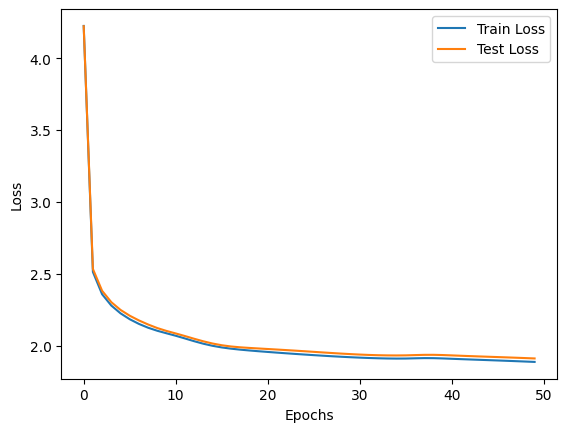

Test Loss:  1.9081342783391484
Test Accuracy:  0.2025


In [11]:
experiment_MLP(ex1,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 2.110919922584198, test_loss: 2.148497458423961
Epoch 20/50 loss: 1.9420287358762873, test_loss: 1.9593118758930446
Epoch 30/50 loss: 1.8851118113853915, test_loss: 1.912105241199281
Epoch 40/50 loss: 1.8451181512133557, test_loss: 1.8754852933445576
Epoch 50/50 loss: 1.8214605670045778, test_loss: 1.8629739698985028


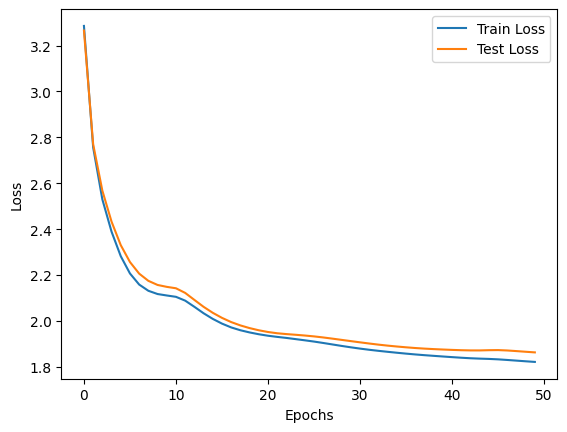

Test Loss:  1.8623651883925207
Test Accuracy:  0.21875


In [12]:
experiment_MLP(ex2,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.8376890088315414, test_loss: 1.8592778256729958
Epoch 20/50 loss: 1.769706788645633, test_loss: 1.8095201186500807
Epoch 30/50 loss: 1.7330662945123065, test_loss: 1.7930147755919135
Epoch 40/50 loss: 1.6955610030265398, test_loss: 1.7815001641755523
Epoch 50/50 loss: 1.6585584516216072, test_loss: 1.774784373816429


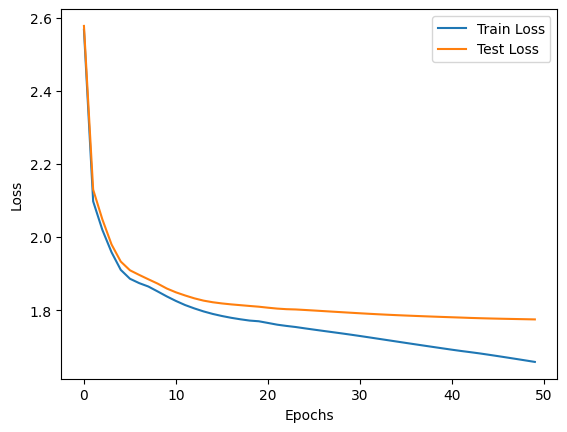

Test Loss:  1.764937702590017
Test Accuracy:  0.25916666666666666


In [13]:
experiment_MLP(ex3,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.7704839529654313, test_loss: 1.7976143843911219
Epoch 20/50 loss: 1.7162916679040692, test_loss: 1.7725808114419541
Epoch 30/50 loss: 1.6537848723507487, test_loss: 1.760664842162028
Epoch 40/50 loss: 1.5863809113309997, test_loss: 1.7646760462791637
Epoch 50/50 loss: 1.5200742281233268, test_loss: 1.7672318287790456


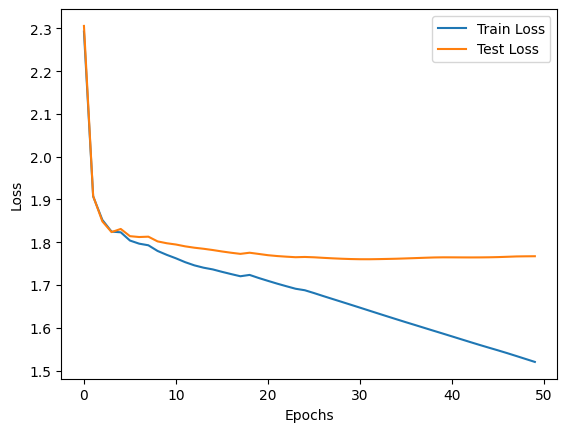

Test Loss:  1.74085700953459
Test Accuracy:  0.3154166666666667


In [14]:
experiment_MLP(ex4,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.9468605835870627, test_loss: 1.9664170968549153
Epoch 20/50 loss: 1.859398991594376, test_loss: 1.8769048992535362
Epoch 30/50 loss: 1.8285373328750711, test_loss: 1.8464803596128885
Epoch 40/50 loss: 1.8104922322826484, test_loss: 1.828249015233708
Epoch 50/50 loss: 1.798136705388847, test_loss: 1.815066430553189


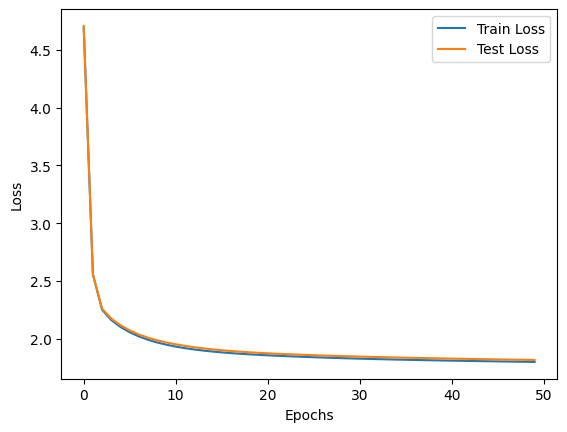

Test Loss:  1.8140632908961853
Test Accuracy:  0.205


In [15]:
experiment_MLP(ex5,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.8727232700407057, test_loss: 1.8495853726420228
Epoch 20/50 loss: 1.8354028179971733, test_loss: 1.8321553240851713
Epoch 30/50 loss: 1.80872365083694, test_loss: 1.8058475089786565
Epoch 40/50 loss: 1.7981266419953745, test_loss: 1.7937834459450157
Epoch 50/50 loss: 1.7926406373626462, test_loss: 1.792945227091067


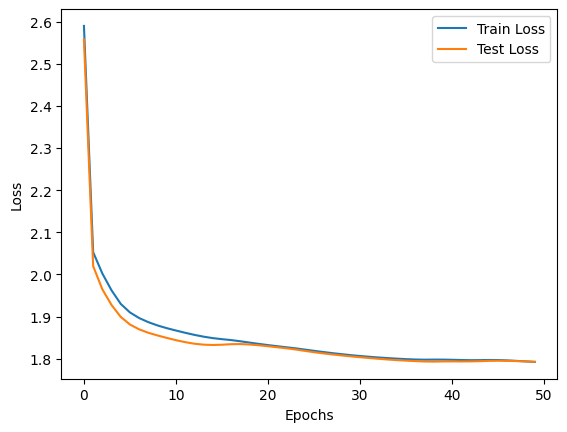

Test Loss:  1.7935092634665637
Test Accuracy:  0.21333333333333335


In [16]:
experiment_MLP(ex6,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.7917741435839343, test_loss: 1.8038312490073656
Epoch 20/50 loss: 1.7623062951843618, test_loss: 1.788158139075462
Epoch 30/50 loss: 1.739693644409153, test_loss: 1.7808560388730037
Epoch 40/50 loss: 1.7164427058730356, test_loss: 1.7751006094432629
Epoch 50/50 loss: 1.6930938559344906, test_loss: 1.7719449902371867


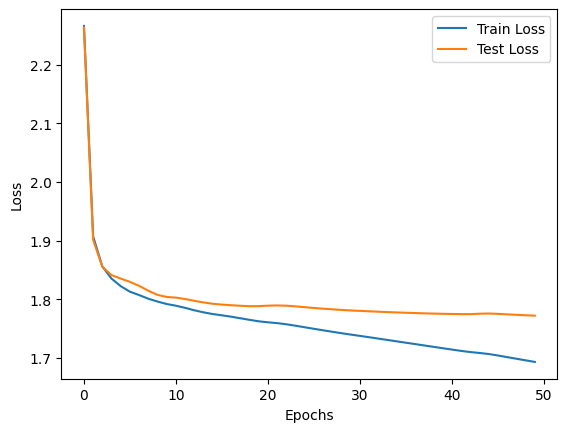

Test Loss:  1.77075179991227
Test Accuracy:  0.24375


In [17]:
experiment_MLP(ex7,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.7741939353987315, test_loss: 1.788456794887992
Epoch 20/50 loss: 1.7352691262792677, test_loss: 1.7745115301490675
Epoch 30/50 loss: 1.6870333348995858, test_loss: 1.7578384586462978
Epoch 40/50 loss: 1.6366979572444802, test_loss: 1.749876156808364
Epoch 50/50 loss: 1.5868581087420788, test_loss: 1.7448558612709264


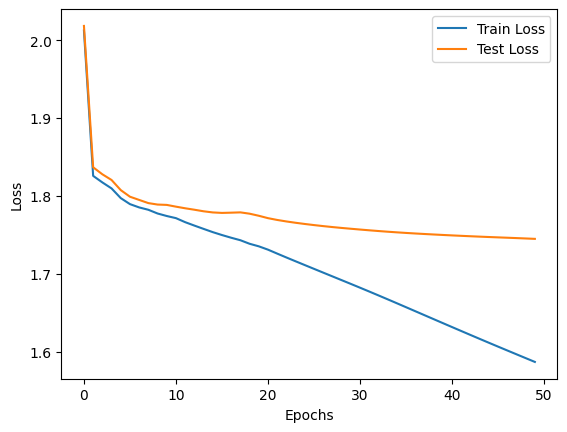

Test Loss:  1.72387116175374
Test Accuracy:  0.295


In [18]:
experiment_MLP(ex8,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.884571096142084, test_loss: 1.8815605090751077
Epoch 20/50 loss: 1.8286706630024352, test_loss: 1.8306485422046153
Epoch 30/50 loss: 1.8132638877109108, test_loss: 1.8164666429230136
Epoch 40/50 loss: 1.8067755474424374, test_loss: 1.8104946588788282
Epoch 50/50 loss: 1.8030434611945554, test_loss: 1.8071716210244293


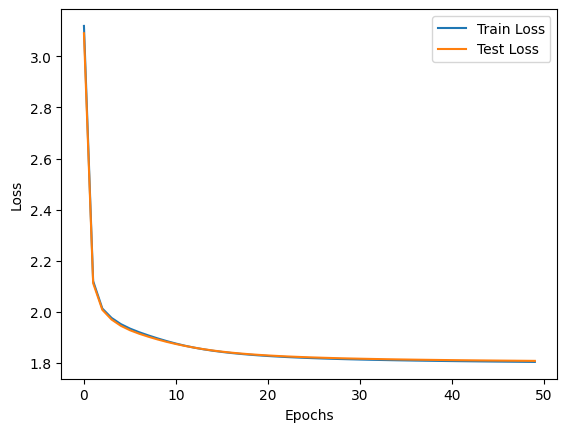

Test Loss:  1.8073265248740555
Test Accuracy:  0.20166666666666666


In [19]:
experiment_MLP(ex9,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.8164706188862418, test_loss: 1.8267676806736812
Epoch 20/50 loss: 1.8050607356153712, test_loss: 1.8099587644293353
Epoch 30/50 loss: 1.8037494778257155, test_loss: 1.8047541755335423
Epoch 40/50 loss: 1.7948190309019514, test_loss: 1.7959391082277398
Epoch 50/50 loss: 1.7919150505485675, test_loss: 1.7947336984705176


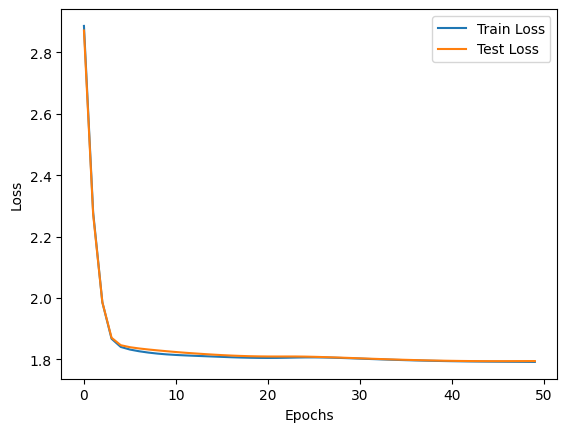

Test Loss:  1.7947386527733367
Test Accuracy:  0.19791666666666666


In [20]:
experiment_MLP(ex10,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.7867417525705818, test_loss: 1.7912371196670316
Epoch 20/50 loss: 1.7673339012126499, test_loss: 1.7797956455640118
Epoch 30/50 loss: 1.75195791938063, test_loss: 1.7743645477310588
Epoch 40/50 loss: 1.7367884367134778, test_loss: 1.7679426861982688
Epoch 50/50 loss: 1.7212155469987176, test_loss: 1.7611886741897982


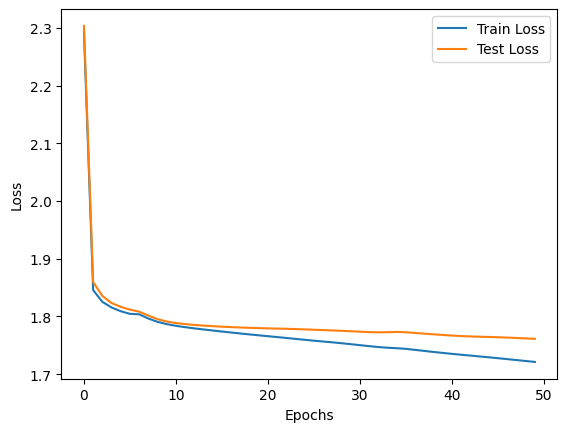

Test Loss:  1.760657525398642
Test Accuracy:  0.25083333333333335


In [21]:
experiment_MLP(ex11,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.7758134028953294, test_loss: 1.7922455665428787
Epoch 20/50 loss: 1.746558361279588, test_loss: 1.7681950833589644
Epoch 30/50 loss: 1.722223076215729, test_loss: 1.754921075712732
Epoch 40/50 loss: 1.6985856781776814, test_loss: 1.7453879654364362
Epoch 50/50 loss: 1.675195300826706, test_loss: 1.7377938076945543


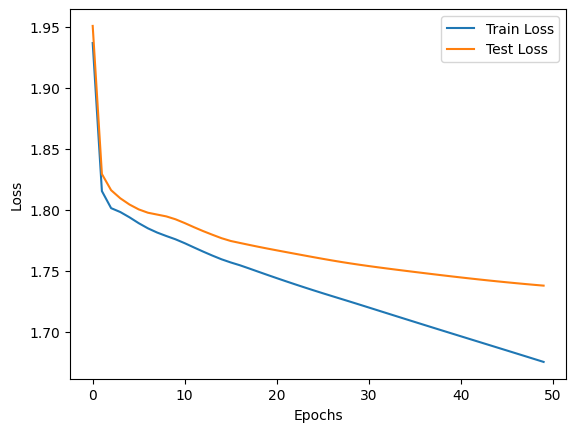

Test Loss:  1.7431435392647465
Test Accuracy:  0.25458333333333333


In [22]:
experiment_MLP(ex12,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 7.249254176416262, test_loss: 7.510251710941357
Epoch 20/50 loss: 3.4862337003391364, test_loss: 3.6934580633320895
Epoch 30/50 loss: 3.0388528035960665, test_loss: 3.24937297042085
Epoch 40/50 loss: 3.999301809596438, test_loss: 4.232477946340085
Epoch 50/50 loss: 4.501355217947292, test_loss: 4.902763635111335


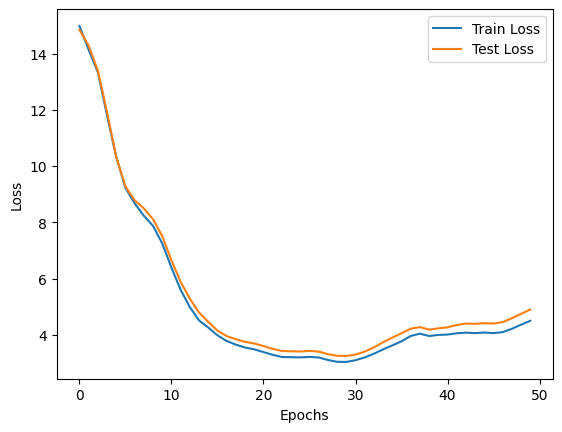

Test Loss:  4.773908032473611
Test Accuracy:  0.2375


In [23]:
experiment_MLP(ex13,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 4.539879942462823, test_loss: 4.694286941311989
Epoch 20/50 loss: 3.4658677666586044, test_loss: 3.642223650132177
Epoch 30/50 loss: 2.6202327470897915, test_loss: 2.837177246335074
Epoch 40/50 loss: 2.2035304659192563, test_loss: 2.523487406369132
Epoch 50/50 loss: 1.964070671679182, test_loss: 2.3286051006943436


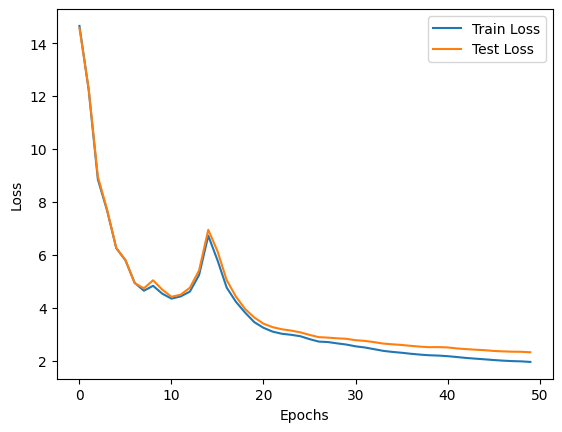

Test Loss:  2.2323217666278854
Test Accuracy:  0.28375


In [11]:
experiment_MLP(ex14,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 3.1256141322651803, test_loss: 3.2219537239044884
Epoch 20/50 loss: 2.8698704728600766, test_loss: 3.2592768734071997
Epoch 30/50 loss: 2.0104305373002127, test_loss: 2.165660822841864
Epoch 40/50 loss: 1.7653464018511693, test_loss: 1.9417221937603721
Epoch 50/50 loss: 1.7251340111221658, test_loss: 1.9106279447217498


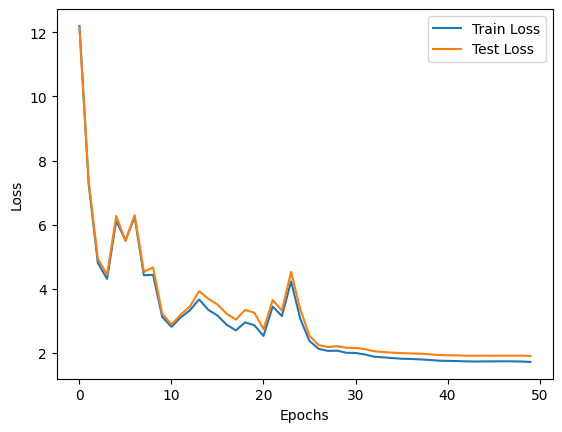

Test Loss:  1.9887839157031555
Test Accuracy:  0.2675


In [12]:
experiment_MLP(ex15,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 2.759959119221301, test_loss: 2.8828722716772996
Epoch 20/50 loss: 2.289286724742829, test_loss: 2.4430485845149996
Epoch 30/50 loss: 1.9746700434826372, test_loss: 2.2094344468270606
Epoch 40/50 loss: 1.7334100521654174, test_loss: 2.003242907544491
Epoch 50/50 loss: 1.6819877867709847, test_loss: 1.9536777465265391


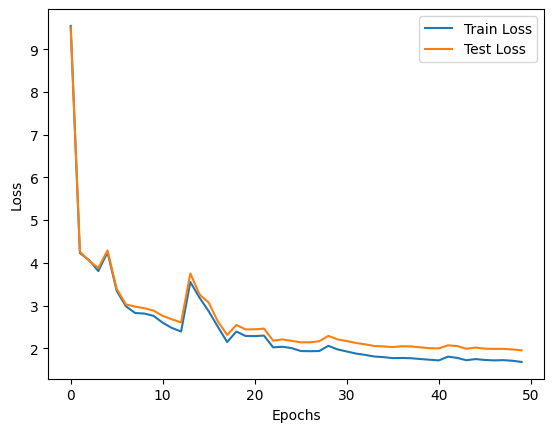

Test Loss:  1.919469423011296
Test Accuracy:  0.2808333333333333


In [13]:
experiment_MLP(ex16,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 5.547073797934765, test_loss: 5.502778763351245
Epoch 20/50 loss: 3.055714534503787, test_loss: 3.1199752407153016
Epoch 30/50 loss: 2.2153206269896315, test_loss: 2.2202243292358146
Epoch 40/50 loss: 2.0954907760020443, test_loss: 2.154747576089616
Epoch 50/50 loss: 1.9466207500748651, test_loss: 2.0208861489328274


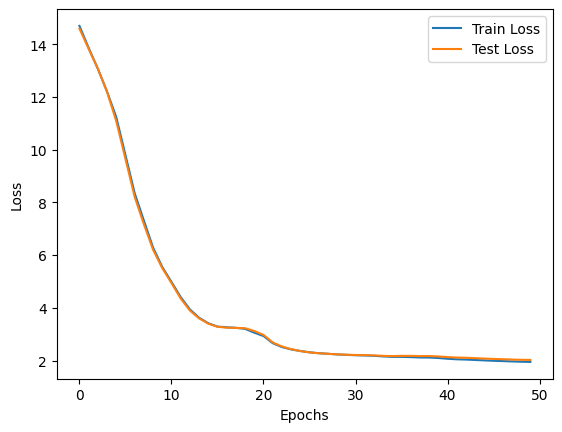

Test Loss:  1.9976793400611519
Test Accuracy:  0.24291666666666667


In [14]:
experiment_MLP(ex17,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 2.713270694011654, test_loss: 2.7567563197062235
Epoch 20/50 loss: 3.094852674984995, test_loss: 3.2902930788100764
Epoch 30/50 loss: 2.598536869181988, test_loss: 2.7350541343994657
Epoch 40/50 loss: 2.2260773313672066, test_loss: 2.446616665144211
Epoch 50/50 loss: 2.2450986665667383, test_loss: 2.503130840317553


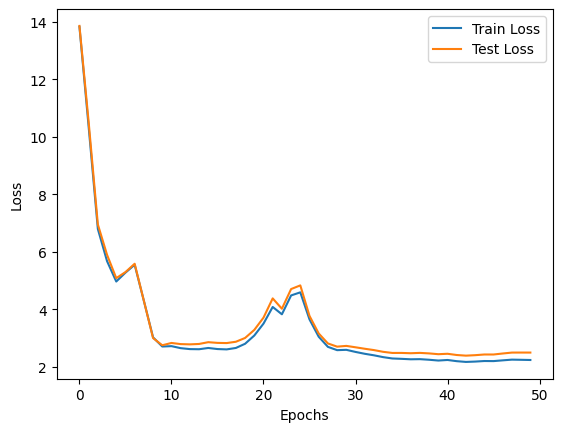

Test Loss:  2.5489260241121072
Test Accuracy:  0.24041666666666667


In [15]:
experiment_MLP(ex18,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 2.4232715950366273, test_loss: 2.5682228739201003
Epoch 20/50 loss: 1.883988036239839, test_loss: 1.977760927600159
Epoch 30/50 loss: 1.805081437162875, test_loss: 1.8743266080171535
Epoch 40/50 loss: 1.7257028441849185, test_loss: 1.798697394403376
Epoch 50/50 loss: 1.6760668953602795, test_loss: 1.7870067330942951


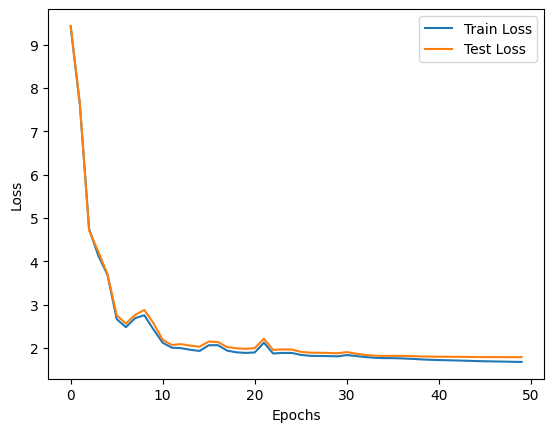

Test Loss:  1.7706970653287064
Test Accuracy:  0.27875


In [16]:
experiment_MLP(ex19,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.9250248109826311, test_loss: 1.9943924296253381
Epoch 20/50 loss: 1.7853883560109716, test_loss: 1.8695567842600413
Epoch 30/50 loss: 1.744143549502755, test_loss: 1.8366701040499132
Epoch 40/50 loss: 1.7497745079874434, test_loss: 1.8593507993702163
Epoch 50/50 loss: 1.6618816146210191, test_loss: 1.8078316134196515


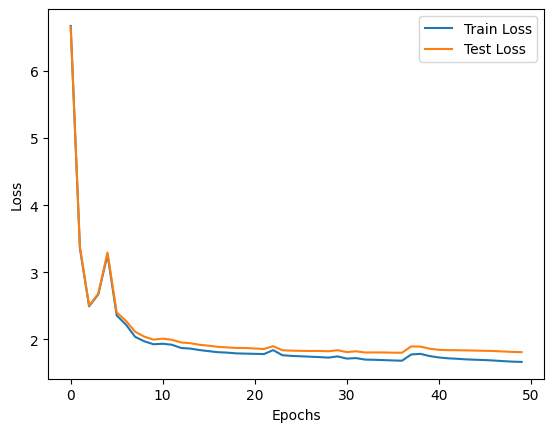

Test Loss:  1.8190091749843798
Test Accuracy:  0.2604166666666667


In [17]:
experiment_MLP(ex20,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 3.195566523635291, test_loss: 3.2896511090758156
Epoch 20/50 loss: 2.0828219124623573, test_loss: 2.111045665131871
Epoch 30/50 loss: 2.4282109467522006, test_loss: 2.4821867670748072
Epoch 40/50 loss: 2.0995768611011405, test_loss: 2.1663987641423943
Epoch 50/50 loss: 2.037511111400094, test_loss: 2.105624295431487


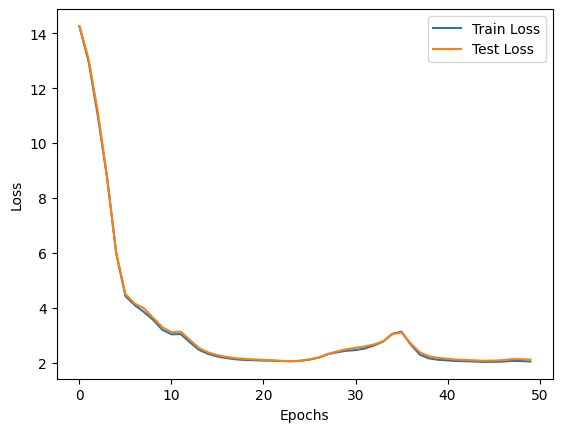

Test Loss:  2.058440140916677
Test Accuracy:  0.20916666666666667


In [18]:
experiment_MLP(ex21,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 2.22404340788106, test_loss: 2.288788222560157
Epoch 20/50 loss: 2.1916780133129006, test_loss: 2.2083184746805387
Epoch 30/50 loss: 2.0693619877870835, test_loss: 2.1303508278280705
Epoch 40/50 loss: 1.877363251951402, test_loss: 1.9387690777613467
Epoch 50/50 loss: 1.817435961892182, test_loss: 1.8798061252430243


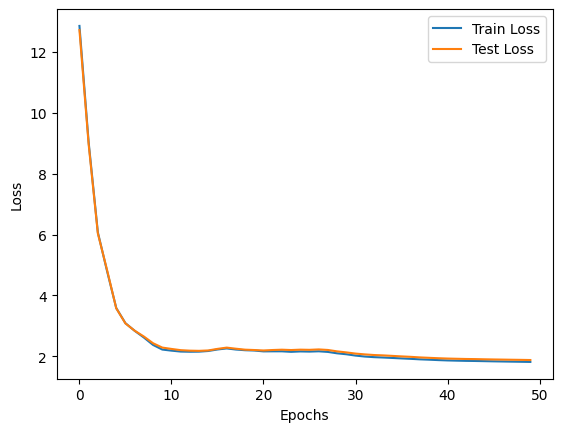

Test Loss:  1.8758688351791484
Test Accuracy:  0.23166666666666666


In [19]:
experiment_MLP(ex22,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.9977872644333312, test_loss: 2.0491261376616867
Epoch 20/50 loss: 1.8249097371274077, test_loss: 1.8334849325953497
Epoch 30/50 loss: 1.771864825921666, test_loss: 1.807148949408504
Epoch 40/50 loss: 1.7534196405308955, test_loss: 1.8006870688776746
Epoch 50/50 loss: 1.7230941969408484, test_loss: 1.7715655658619236


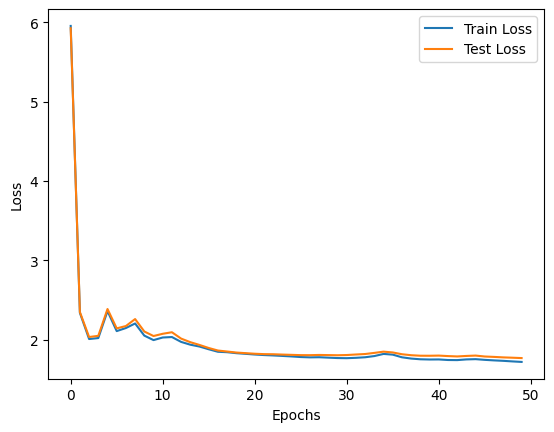

Test Loss:  1.7686335997583926
Test Accuracy:  0.2529166666666667


In [20]:
experiment_MLP(ex23,MLP_EXPERIMENT_LOSS_2LAYER)

Epoch 10/50 loss: 1.7162041000756199, test_loss: 1.766697178363026
Epoch 20/50 loss: 1.6266984889405645, test_loss: 1.7143272670368461
Epoch 30/50 loss: 1.541670219726058, test_loss: 1.6839772356815956
Epoch 40/50 loss: 1.480047737141622, test_loss: 1.6754531289048051
Epoch 50/50 loss: 1.4207670996101411, test_loss: 1.682965760291351


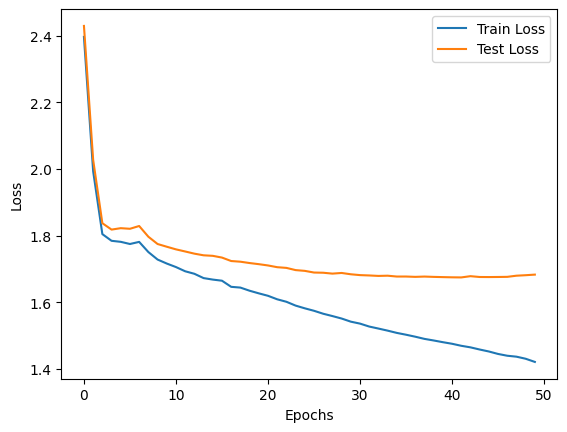

Test Loss:  1.666883710341807
Test Accuracy:  0.3516666666666667


In [21]:
experiment_MLP(ex24,MLP_EXPERIMENT_LOSS_2LAYER)

## 1 Hidden Layer

In [10]:
input_size = 32*32
output_size = 6
activation = ["sigmoid","relu"]
hidden_size = [[256],[128],[64]]
learning_rate = [0.01,0.001]
batch_size = [32,16]
epoch = 50

ex1 = [activation[0],hidden_size[0],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex2 = [activation[0],hidden_size[0],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex3 = [activation[0],hidden_size[0],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex4 = [activation[0],hidden_size[0],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex5 = [activation[0],hidden_size[1],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex6 = [activation[0],hidden_size[1],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex7 = [activation[0],hidden_size[1],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex8 = [activation[0],hidden_size[1],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex9 = [activation[0],hidden_size[2],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex10 = [activation[0],hidden_size[2],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex11 = [activation[0],hidden_size[2],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex12 = [activation[0],hidden_size[2],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex13 = [activation[1],hidden_size[0],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex14 = [activation[1],hidden_size[0],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex15 = [activation[1],hidden_size[0],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex16 = [activation[1],hidden_size[0],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex17 = [activation[1],hidden_size[1],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex18 = [activation[1],hidden_size[1],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex19 = [activation[1],hidden_size[1],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex20 = [activation[1],hidden_size[1],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex21 = [activation[1],hidden_size[2],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex22 = [activation[1],hidden_size[2],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex23 = [activation[1],hidden_size[2],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex24 = [activation[1],hidden_size[2],learning_rate[0],epoch,batch_size[1],input_size,output_size]

MLP_EXPERIMENT_LOSS_1LAYER = []

Epoch 10/50 loss: 3.494886294742603, test_loss: 3.4315187897891763
Epoch 20/50 loss: 2.961307630446854, test_loss: 2.9571103136733567
Epoch 30/50 loss: 2.643479053973558, test_loss: 2.6704344666062507
Epoch 40/50 loss: 2.434355209274102, test_loss: 2.4737698784962476
Epoch 50/50 loss: 2.2957891401440733, test_loss: 2.335118089483618


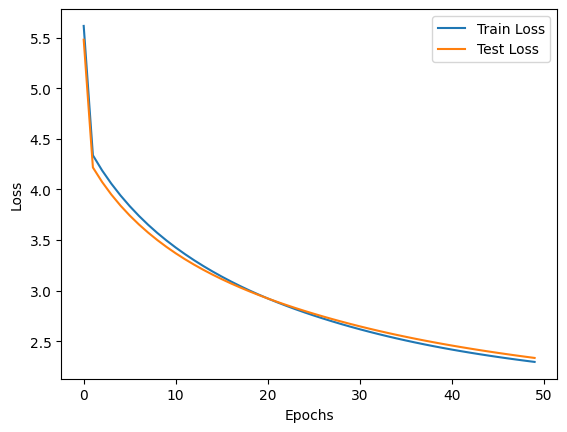

Test Loss:  2.329327753748949
Test Accuracy:  0.19583333333333333


In [26]:
experiment_MLP(ex1,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 3.082759914103894, test_loss: 3.096249331415649
Epoch 20/50 loss: 2.538368131880366, test_loss: 2.585054456929011
Epoch 30/50 loss: 2.2752801812407246, test_loss: 2.3271370743151176
Epoch 40/50 loss: 2.126334665721292, test_loss: 2.1736748083190656
Epoch 50/50 loss: 2.032848469718768, test_loss: 2.076468776677089


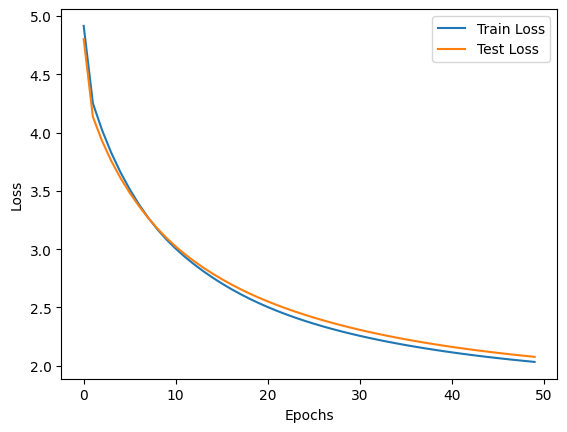

Test Loss:  2.0723737820159407
Test Accuracy:  0.19666666666666666


In [27]:
experiment_MLP(ex2,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 2.0833922375750755, test_loss: 2.101684080020989
Epoch 20/50 loss: 1.865227659115108, test_loss: 1.8848818886493253
Epoch 30/50 loss: 1.816727420366504, test_loss: 1.8386556283679871
Epoch 40/50 loss: 1.7945472469312767, test_loss: 1.8191386029133354
Epoch 50/50 loss: 1.7808678278968, test_loss: 1.8081801404266475


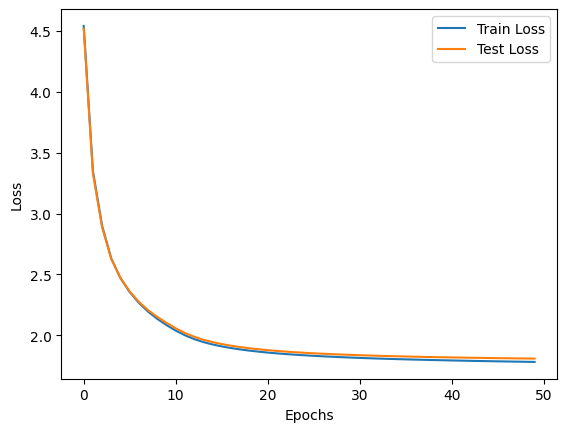

Test Loss:  1.802632794159056
Test Accuracy:  0.22125


In [28]:
experiment_MLP(ex3,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8963304427191447, test_loss: 1.8973234533331622
Epoch 20/50 loss: 1.8085923859800999, test_loss: 1.8237269518654253
Epoch 30/50 loss: 1.7802683492223408, test_loss: 1.8043574353970955
Epoch 40/50 loss: 1.7641075004395936, test_loss: 1.7945287128400886
Epoch 50/50 loss: 1.7525055942849637, test_loss: 1.7878113748925901


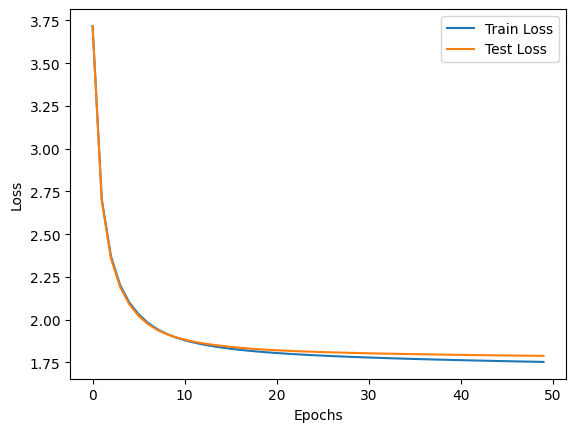

Test Loss:  1.783074890571003
Test Accuracy:  0.22625


In [29]:
experiment_MLP(ex4,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 2.6822765502750583, test_loss: 2.6838501722667982
Epoch 20/50 loss: 2.384646741224084, test_loss: 2.389069007527438
Epoch 30/50 loss: 2.2210392867812048, test_loss: 2.2275165977574884
Epoch 40/50 loss: 2.113276860252131, test_loss: 2.1153834247342127
Epoch 50/50 loss: 2.036926611393013, test_loss: 2.0326516712133182


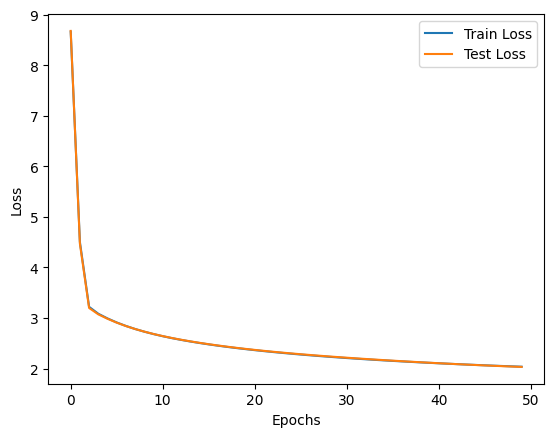

Test Loss:  2.029207230996448
Test Accuracy:  0.17791666666666667


In [30]:
experiment_MLP(ex5,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 2.3475079579981184, test_loss: 2.375419553354187
Epoch 20/50 loss: 2.1085814849778877, test_loss: 2.130226745038314
Epoch 30/50 loss: 1.9886315837165858, test_loss: 1.9989462018671735
Epoch 40/50 loss: 1.9216642509208688, test_loss: 1.9246461500934675
Epoch 50/50 loss: 1.8830533563503005, test_loss: 1.885952662271659


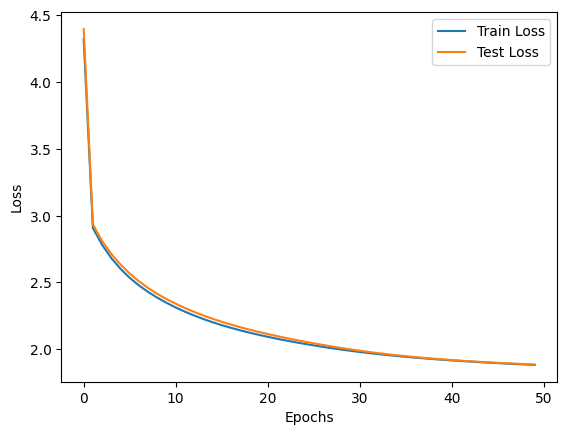

Test Loss:  1.884252874957471
Test Accuracy:  0.19666666666666666


In [31]:
experiment_MLP(ex6,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8659743039741647, test_loss: 1.8662015939446652
Epoch 20/50 loss: 1.8111256736920605, test_loss: 1.8170337622612742
Epoch 30/50 loss: 1.7918006059126756, test_loss: 1.801308517307671
Epoch 40/50 loss: 1.7805321697162466, test_loss: 1.7924657898974465
Epoch 50/50 loss: 1.7726513355898479, test_loss: 1.786405393900801


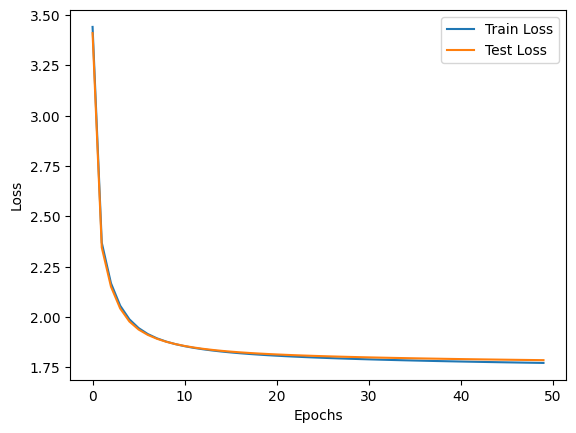

Test Loss:  1.7839199001024606
Test Accuracy:  0.21333333333333335


In [32]:
experiment_MLP(ex7,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8280425177209183, test_loss: 1.8424651012675917
Epoch 20/50 loss: 1.7914205366592653, test_loss: 1.8106776488916818
Epoch 30/50 loss: 1.7765434094410804, test_loss: 1.8001906096099063
Epoch 40/50 loss: 1.7664013005437686, test_loss: 1.7941321979796794
Epoch 50/50 loss: 1.7586162732467945, test_loss: 1.7898448375501175


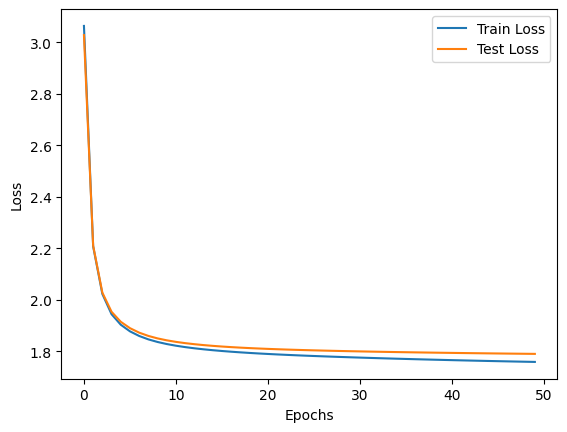

Test Loss:  1.7834410525242947
Test Accuracy:  0.21166666666666667


In [33]:
experiment_MLP(ex8,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 2.4040272466351404, test_loss: 2.3479780905578322
Epoch 20/50 loss: 2.192872884650374, test_loss: 2.1536197666307557
Epoch 30/50 loss: 2.0819890953436135, test_loss: 2.054587498277934
Epoch 40/50 loss: 2.014024258393627, test_loss: 1.9925381539896545
Epoch 50/50 loss: 1.9685017498772455, test_loss: 1.9500343278666954


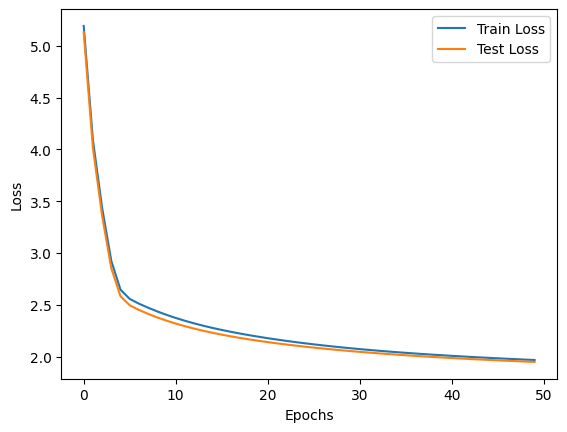

Test Loss:  1.948120758176401
Test Accuracy:  0.16708333333333333


In [34]:
experiment_MLP(ex9,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.973836180045731, test_loss: 1.969936186956091
Epoch 20/50 loss: 1.8798068842883242, test_loss: 1.8689402431748976
Epoch 30/50 loss: 1.8454306600046182, test_loss: 1.8313392759434448
Epoch 40/50 loss: 1.8278512277874306, test_loss: 1.8145422329714218
Epoch 50/50 loss: 1.817501924732242, test_loss: 1.8060058379288952


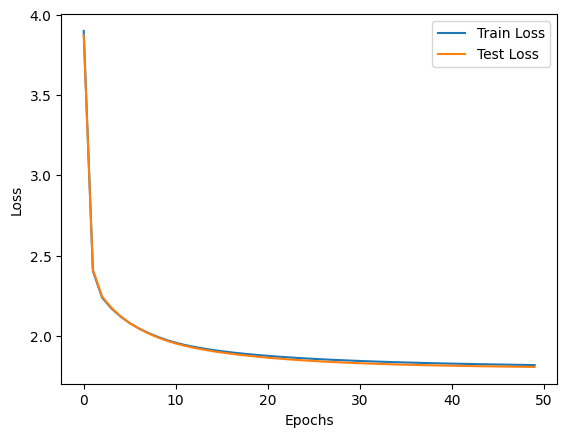

Test Loss:  1.805570453855883
Test Accuracy:  0.1975


In [35]:
experiment_MLP(ex10,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8154823345537812, test_loss: 1.8171061623475846
Epoch 20/50 loss: 1.791279914073992, test_loss: 1.7955198711363214
Epoch 30/50 loss: 1.7824602239506704, test_loss: 1.787404586606677
Epoch 40/50 loss: 1.7774090812633194, test_loss: 1.7826295155308503
Epoch 50/50 loss: 1.7738961586911464, test_loss: 1.7793575558074708


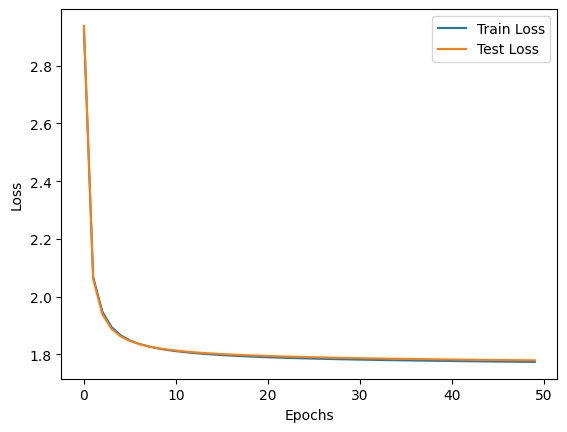

Test Loss:  1.7782233281794535
Test Accuracy:  0.21208333333333335


In [36]:
experiment_MLP(ex11,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.7990794460625572, test_loss: 1.803614957003583
Epoch 20/50 loss: 1.779700742058392, test_loss: 1.7874203388634238
Epoch 30/50 loss: 1.7707261248389203, test_loss: 1.7804660107663195
Epoch 40/50 loss: 1.7654275267232675, test_loss: 1.7777802102356892
Epoch 50/50 loss: 1.7610540427561319, test_loss: 1.7761757602579415


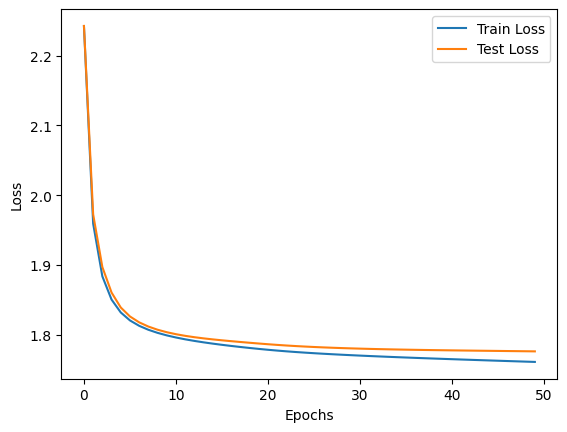

Test Loss:  1.7737272675166829
Test Accuracy:  0.21625


In [37]:
experiment_MLP(ex12,MLP_EXPERIMENT_LOSS_1LAYER)

In [11]:
# RUN BELOW

Epoch 10/50 loss: 11.925364017166466, test_loss: 11.932461572910375
Epoch 20/50 loss: 10.2758959399774, test_loss: 10.562034529598455
Epoch 30/50 loss: 8.765939158589982, test_loss: 9.179177357506127
Epoch 40/50 loss: 7.243945324166393, test_loss: 7.6638264236853155
Epoch 50/50 loss: 5.815764238023677, test_loss: 6.166692206534617


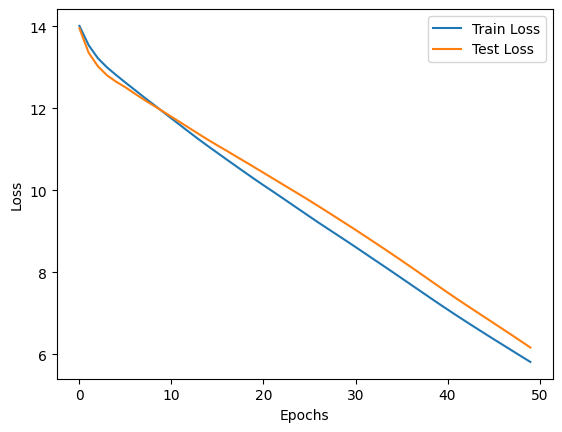

Test Loss:  6.204289057144532
Test Accuracy:  0.22208333333333333


In [12]:
experiment_MLP(ex13,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 9.937726814377632, test_loss: 10.326465082598785
Epoch 20/50 loss: 6.345720879856374, test_loss: 6.739790014343733
Epoch 30/50 loss: 3.661031632339934, test_loss: 3.914454781361558
Epoch 40/50 loss: 2.57266283217765, test_loss: 2.720457964069184
Epoch 50/50 loss: 2.2696904659273955, test_loss: 2.39653930950233


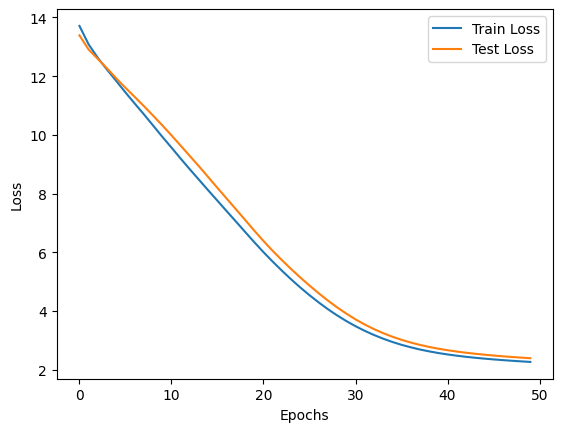

Test Loss:  2.3471750272720358
Test Accuracy:  0.21791666666666668


In [13]:
experiment_MLP(ex14,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 2.122152869221002, test_loss: 2.1568973612645284
Epoch 20/50 loss: 1.8738199507497446, test_loss: 1.9291889692634792
Epoch 30/50 loss: 1.8129339683276176, test_loss: 1.883271072508891
Epoch 40/50 loss: 1.7816682013998946, test_loss: 1.8637303533231193
Epoch 50/50 loss: 1.7608785536553617, test_loss: 1.8511194960403237


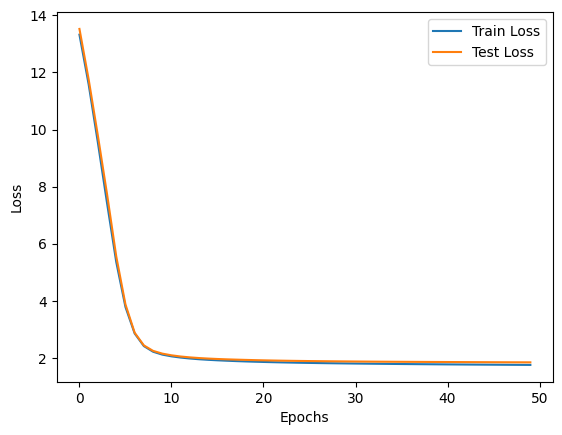

Test Loss:  1.8625050498703892
Test Accuracy:  0.2325


In [14]:
experiment_MLP(ex15,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8748230495684706, test_loss: 1.971584733185332
Epoch 20/50 loss: 1.7878310328297113, test_loss: 1.8918224444293186
Epoch 30/50 loss: 1.753446332983968, test_loss: 1.8711100968847352
Epoch 40/50 loss: 1.7303478253094469, test_loss: 1.8611912455789799
Epoch 50/50 loss: 1.7115835358242824, test_loss: 1.8531947776617737


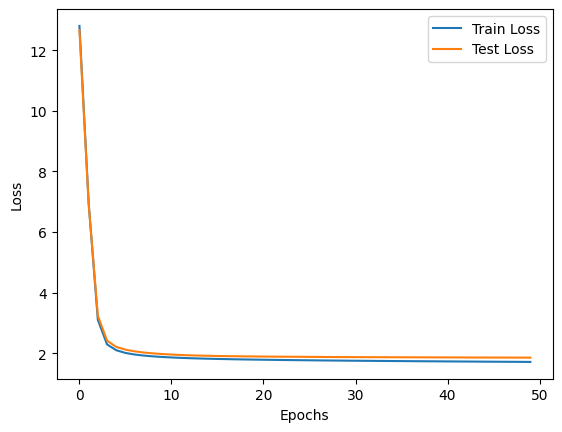

Test Loss:  1.8533115834458567
Test Accuracy:  0.2275


In [15]:
experiment_MLP(ex16,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 10.761197209856434, test_loss: 10.981617042834632
Epoch 20/50 loss: 7.815736892372888, test_loss: 8.079543494446888
Epoch 30/50 loss: 4.792337112913553, test_loss: 5.0667511840425155
Epoch 40/50 loss: 2.90783614488907, test_loss: 3.0493690721593683
Epoch 50/50 loss: 2.201771423230676, test_loss: 2.2660994944576154


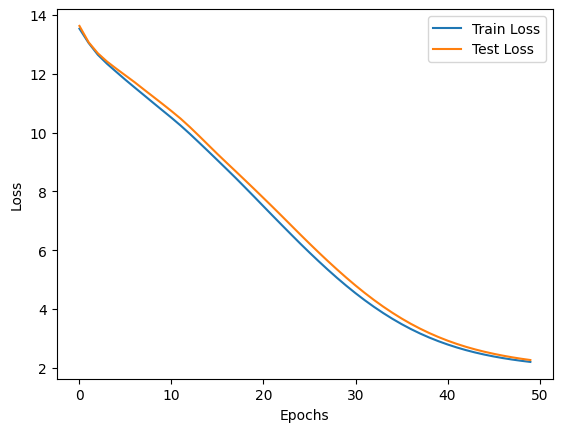

Test Loss:  2.212736555350843
Test Accuracy:  0.21083333333333334


In [16]:
experiment_MLP(ex17,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 8.006826452110467, test_loss: 8.383797874504516
Epoch 20/50 loss: 3.149340978523776, test_loss: 3.3337293437481645
Epoch 30/50 loss: 2.1079605571311526, test_loss: 2.1646863172302515
Epoch 40/50 loss: 1.998074593551694, test_loss: 2.038904666722502
Epoch 50/50 loss: 1.9481380112702356, test_loss: 1.9870306837543714


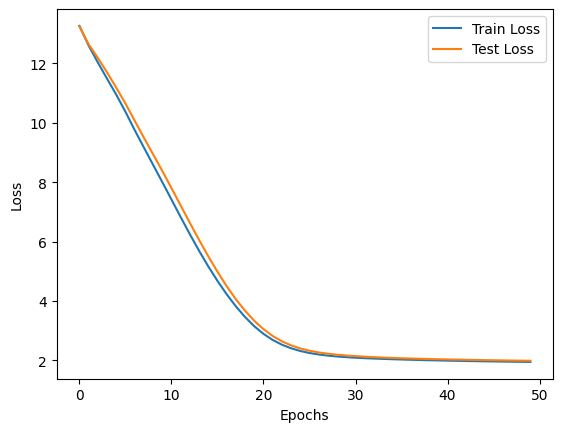

Test Loss:  1.94445969896047
Test Accuracy:  0.19666666666666666


In [17]:
experiment_MLP(ex18,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8946006568684914, test_loss: 1.9171178874415504
Epoch 20/50 loss: 1.8070693217812668, test_loss: 1.8371815455791458
Epoch 30/50 loss: 1.7808224499596683, test_loss: 1.8165279264184777
Epoch 40/50 loss: 1.7652184890170577, test_loss: 1.806259689014195
Epoch 50/50 loss: 1.754476923753265, test_loss: 1.7996831477028112


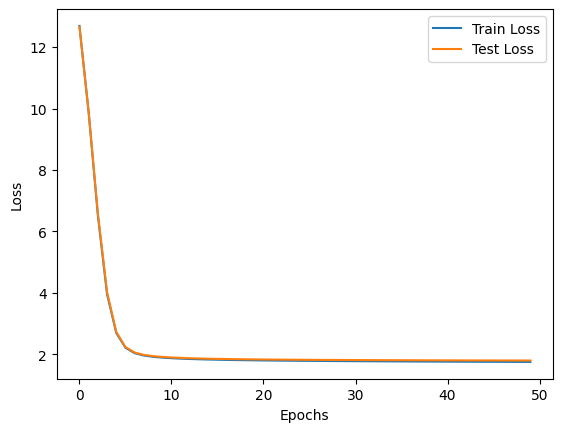

Test Loss:  1.8049669947834945
Test Accuracy:  0.225


In [18]:
experiment_MLP(ex19,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.825258998895922, test_loss: 1.8610510660211337
Epoch 20/50 loss: 1.7764971111819416, test_loss: 1.8162483540301786
Epoch 30/50 loss: 1.756238671261624, test_loss: 1.8034276122636363
Epoch 40/50 loss: 1.7432882521093707, test_loss: 1.795405550101913
Epoch 50/50 loss: 1.7327609615883266, test_loss: 1.7891808670163543


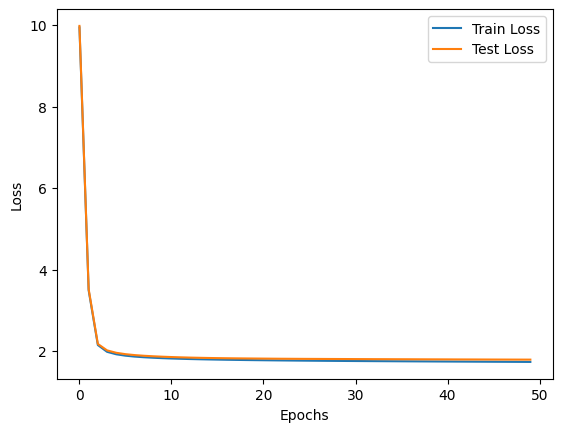

Test Loss:  1.7896399132413217
Test Accuracy:  0.23416666666666666


In [19]:
experiment_MLP(ex20,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 8.53478881131036, test_loss: 8.455417679574252
Epoch 20/50 loss: 4.290212288812496, test_loss: 4.255174210724108
Epoch 30/50 loss: 2.3087062979334094, test_loss: 2.29602564134299
Epoch 40/50 loss: 1.923044321530732, test_loss: 1.917538338042576
Epoch 50/50 loss: 1.8594779442771134, test_loss: 1.8582179076082177


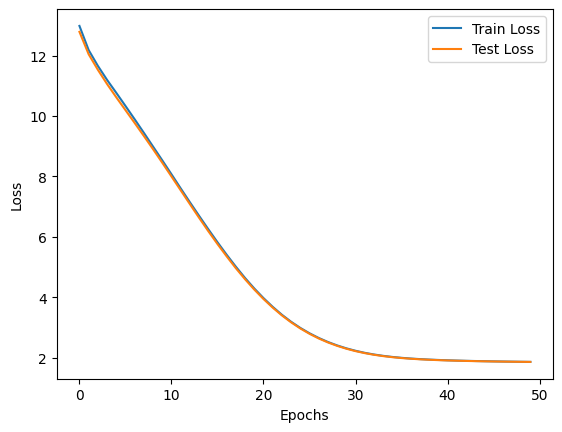

Test Loss:  1.8610324057438545
Test Accuracy:  0.22208333333333333


In [20]:
experiment_MLP(ex21,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 5.0718269498706015, test_loss: 5.123878375465773
Epoch 20/50 loss: 2.0591778932864226, test_loss: 2.078272435534352
Epoch 30/50 loss: 1.87699061015615, test_loss: 1.8950254591041826
Epoch 40/50 loss: 1.8489529894055166, test_loss: 1.868011997154684
Epoch 50/50 loss: 1.8350298471188926, test_loss: 1.8544426295592276


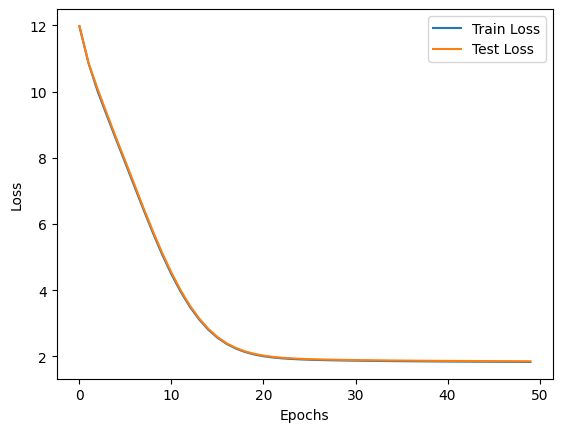

Test Loss:  1.8329754213204346
Test Accuracy:  0.19583333333333333


In [21]:
experiment_MLP(ex22,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8364262822941437, test_loss: 1.849831799779849
Epoch 20/50 loss: 1.7918313349049626, test_loss: 1.8063693860461982
Epoch 30/50 loss: 1.775323980145585, test_loss: 1.7924955396010644
Epoch 40/50 loss: 1.7654549459526465, test_loss: 1.7845109361971716
Epoch 50/50 loss: 1.7575642403404577, test_loss: 1.7784023843126628


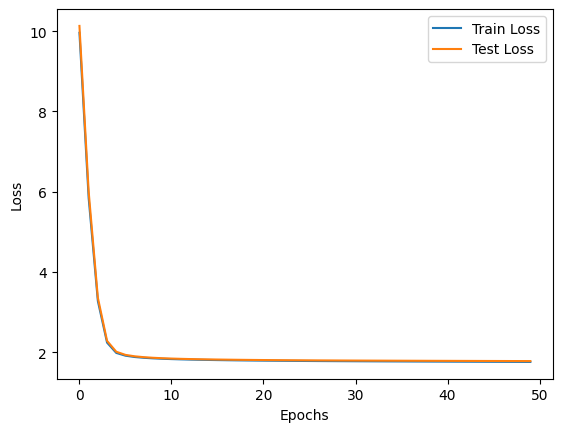

Test Loss:  1.7797616812259613
Test Accuracy:  0.22791666666666666


In [22]:
experiment_MLP(ex23,MLP_EXPERIMENT_LOSS_1LAYER)

Epoch 10/50 loss: 1.8287666351367882, test_loss: 1.8436344642101645
Epoch 20/50 loss: 1.7953286819003642, test_loss: 1.8158673360263704
Epoch 30/50 loss: 1.7791109668753151, test_loss: 1.8071020323850606
Epoch 40/50 loss: 1.7690981097880574, test_loss: 1.802123195625523
Epoch 50/50 loss: 1.760858125170167, test_loss: 1.797503429174222


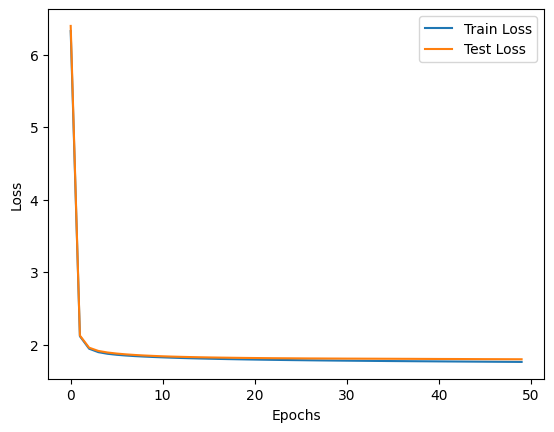

Test Loss:  1.799136728316752
Test Accuracy:  0.22375


In [23]:
experiment_MLP(ex24,MLP_EXPERIMENT_LOSS_1LAYER)

## 0 Hidden Layer

In [30]:
input_size = 32*32
output_size = 6
activation = ["sigmoid","relu"]
hidden_size = [[]]
learning_rate = [0.01,0.001]
batch_size = [32,16]
epoch = 100

ex1 = [activation[0],hidden_size[0],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex2 = [activation[0],hidden_size[0],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex3 = [activation[0],hidden_size[0],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex4 = [activation[0],hidden_size[0],learning_rate[0],epoch,batch_size[1],input_size,output_size]
ex5 = [activation[1],hidden_size[0],learning_rate[1],epoch,batch_size[0],input_size,output_size]
ex6 = [activation[1],hidden_size[0],learning_rate[1],epoch,batch_size[1],input_size,output_size]
ex7 = [activation[1],hidden_size[0],learning_rate[0],epoch,batch_size[0],input_size,output_size]
ex8 = [activation[1],hidden_size[0],learning_rate[0],epoch,batch_size[1],input_size,output_size]
MLP_EXPERIMENT_LOSS_0LAYER = []  

Epoch 10/100 loss: 4.430127327927683, test_loss: 4.4875526858330534
Epoch 20/100 loss: 4.2005677819489975, test_loss: 4.253226002545837
Epoch 30/100 loss: 4.0236744755591385, test_loss: 4.0735572104336235
Epoch 40/100 loss: 3.8889321681160696, test_loss: 3.9372432961351795
Epoch 50/100 loss: 3.784391174619011, test_loss: 3.832029059756566
Epoch 60/100 loss: 3.6998530515319286, test_loss: 3.747608608146729
Epoch 70/100 loss: 3.628303316784242, test_loss: 3.6768163149055235
Epoch 80/100 loss: 3.5654466021639, test_loss: 3.6151904882076207
Epoch 90/100 loss: 3.5087497701873365, test_loss: 3.5600516973647593
Epoch 100/100 loss: 3.4567063693475863, test_loss: 3.509775644024131


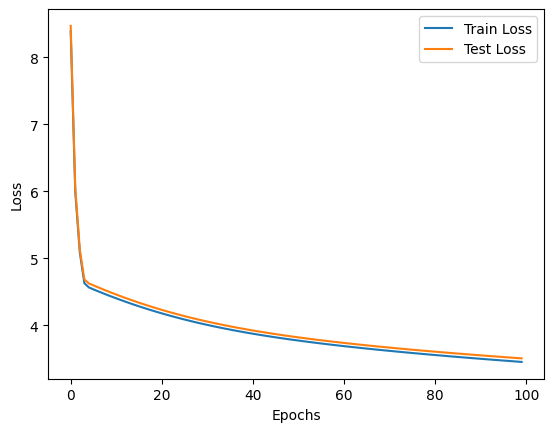

Test Loss:  3.5073412396387056
Test Accuracy:  0.1675


In [25]:
experiment_MLP(ex1,MLP_EXPERIMENT_LOSS_0LAYER)

Epoch 10/100 loss: 4.269657641368504, test_loss: 4.224644160642472
Epoch 20/100 loss: 3.9118486447907586, test_loss: 3.8680683969100587
Epoch 30/100 loss: 3.6842190060636546, test_loss: 3.6460431101293036
Epoch 40/100 loss: 3.522999971313992, test_loss: 3.491189223063187
Epoch 50/100 loss: 3.3979622911297374, test_loss: 3.3718272188299734
Epoch 60/100 loss: 3.2947963044283397, test_loss: 3.2735189065547337
Epoch 70/100 loss: 3.206393725892583, test_loss: 3.1893722436670364
Epoch 80/100 loss: 3.1288669949410908, test_loss: 3.1157211951261106
Epoch 90/100 loss: 3.059851164047174, test_loss: 3.05035453686198
Epoch 100/100 loss: 2.9977740165109403, test_loss: 2.9917925085594934


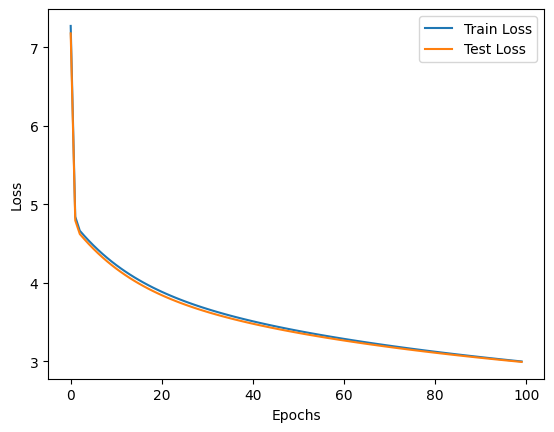

Test Loss:  2.988596612176773
Test Accuracy:  0.19375


In [26]:
experiment_MLP(ex2,MLP_EXPERIMENT_LOSS_0LAYER)

Epoch 10/100 loss: 3.4057937209152054, test_loss: 3.4240335037508136
Epoch 20/100 loss: 3.017933173081077, test_loss: 3.047604142673294
Epoch 30/100 loss: 2.7866972934279843, test_loss: 2.829464012309924
Epoch 40/100 loss: 2.6280664619235554, test_loss: 2.682925974028911
Epoch 50/100 loss: 2.511143329049478, test_loss: 2.576413039729379
Epoch 60/100 loss: 2.4208357906842655, test_loss: 2.494777181232457
Epoch 70/100 loss: 2.3485114542549064, test_loss: 2.429616628418507
Epoch 80/100 loss: 2.2888090700989845, test_loss: 2.3758856603648026
Epoch 90/100 loss: 2.238250856997579, test_loss: 2.3304025637129815
Epoch 100/100 loss: 2.194514823886453, test_loss: 2.2910852876144934


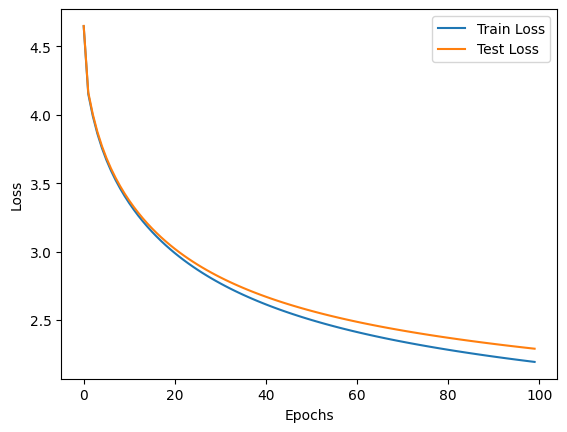

Test Loss:  2.2937765141743567
Test Accuracy:  0.24083333333333334


In [27]:
experiment_MLP(ex3,MLP_EXPERIMENT_LOSS_0LAYER)

Epoch 10/100 loss: 3.0922078355258167, test_loss: 3.1750188106920825
Epoch 20/100 loss: 2.6733871275602508, test_loss: 2.7705105709313442
Epoch 30/100 loss: 2.461840232390925, test_loss: 2.5673138311613557
Epoch 40/100 loss: 2.329130684596756, test_loss: 2.440670076179756
Epoch 50/100 loss: 2.233986892908124, test_loss: 2.351204690370132
Epoch 60/100 loss: 2.159750309819383, test_loss: 2.282712037286619
Epoch 70/100 loss: 2.098699661893805, test_loss: 2.2275032170817917
Epoch 80/100 loss: 2.0467884009648913, test_loss: 2.181472005282063
Epoch 90/100 loss: 2.0016560676693325, test_loss: 2.1421901023649963
Epoch 100/100 loss: 1.9617993490145533, test_loss: 2.108098954169961


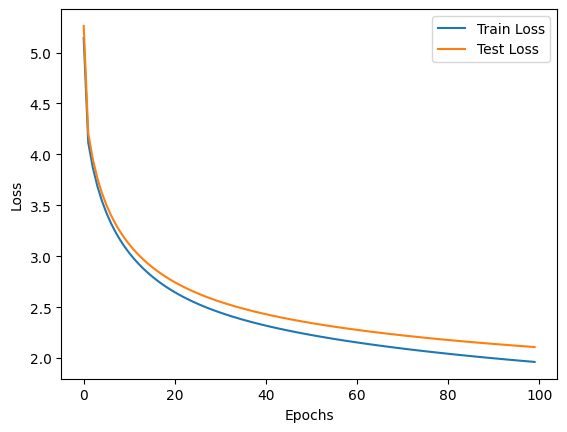

Test Loss:  2.0978864923607143
Test Accuracy:  0.26208333333333333


In [28]:
experiment_MLP(ex4,MLP_EXPERIMENT_LOSS_0LAYER)

Epoch 10/100 loss: 4.366666799778098, test_loss: 4.4830601404002515
Epoch 20/100 loss: 4.213687362446861, test_loss: 4.323596913715674
Epoch 30/100 loss: 4.082236436408051, test_loss: 4.186155600135243
Epoch 40/100 loss: 3.968098192377719, test_loss: 4.066531199276764
Epoch 50/100 loss: 3.867917960355243, test_loss: 3.9613544950312134
Epoch 60/100 loss: 3.779115352209022, test_loss: 3.8680310096001307
Epoch 70/100 loss: 3.699722057378576, test_loss: 3.784582086160317
Epoch 80/100 loss: 3.6282201124833886, test_loss: 3.70948075216822
Epoch 90/100 loss: 3.5634125218797537, test_loss: 3.6415219949401716
Epoch 100/100 loss: 3.5043319515209124, test_loss: 3.579730344250767


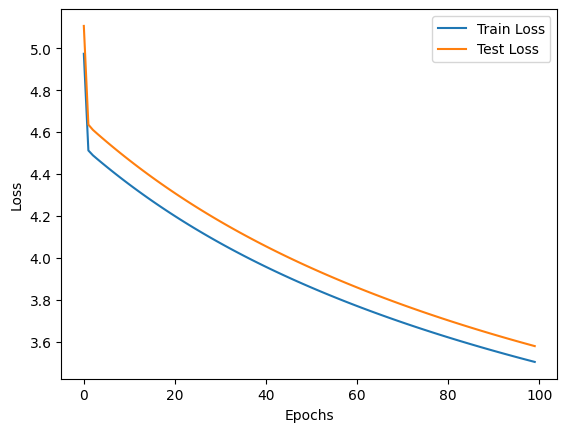

Test Loss:  3.577072540789856
Test Accuracy:  0.18125


In [31]:
experiment_MLP(ex5,MLP_EXPERIMENT_LOSS_0LAYER)

Epoch 10/100 loss: 4.172571556134559, test_loss: 4.215903666771812
Epoch 20/100 loss: 3.874957700513737, test_loss: 3.9144234079567273
Epoch 30/100 loss: 3.6636530076030933, test_loss: 3.7027204890012513
Epoch 40/100 loss: 3.503847128413084, test_loss: 3.5437532816839363
Epoch 50/100 loss: 3.3768151443872325, test_loss: 3.4179990366001416
Epoch 60/100 loss: 3.271925064344343, test_loss: 3.3146054480493286
Epoch 70/100 loss: 3.1828309761196145, test_loss: 3.2271473169228164
Epoch 80/100 loss: 3.105538767251434, test_loss: 3.1515800359989368
Epoch 90/100 loss: 3.037396125451196, test_loss: 3.0852176440897234
Epoch 100/100 loss: 2.9765589261518084, test_loss: 3.0261960885304733


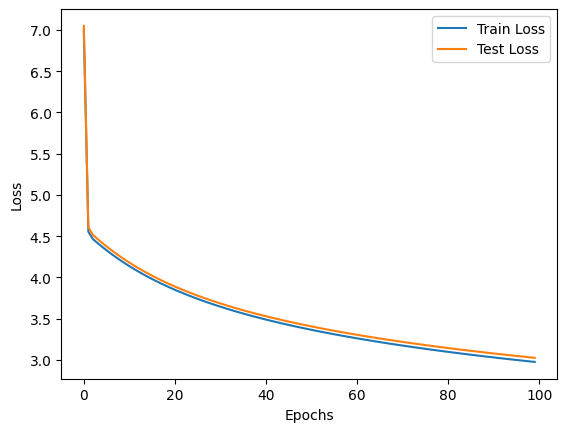

Test Loss:  3.023507129235867
Test Accuracy:  0.19625


In [32]:
experiment_MLP(ex6,MLP_EXPERIMENT_LOSS_0LAYER)

Epoch 10/100 loss: 3.4847781447012562, test_loss: 3.561135344387624
Epoch 20/100 loss: 3.043015511239716, test_loss: 3.1095696191877105
Epoch 30/100 loss: 2.8014172329588756, test_loss: 2.8643809830510856
Epoch 40/100 loss: 2.6403590668606367, test_loss: 2.7038100480412415
Epoch 50/100 loss: 2.522518950942163, test_loss: 2.5888959095239876
Epoch 60/100 loss: 2.4315773074350715, test_loss: 2.502157267284621
Epoch 70/100 loss: 2.358700153480087, test_loss: 2.434065216369826
Epoch 80/100 loss: 2.298508475673065, test_loss: 2.3788695341281345
Epoch 90/100 loss: 2.2475205494276325, test_loss: 2.332900652049941
Epoch 100/100 loss: 2.2034026011985883, test_loss: 2.2937320899107756


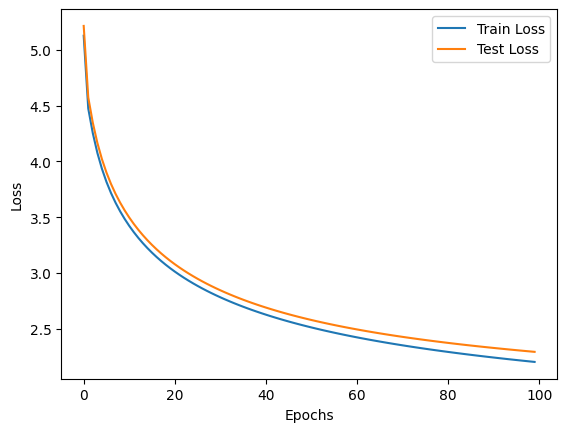

Test Loss:  2.299792819636688
Test Accuracy:  0.23041666666666666


In [33]:
experiment_MLP(ex7,MLP_EXPERIMENT_LOSS_0LAYER)

Epoch 10/100 loss: 3.0593867122114524, test_loss: 3.102954475304783
Epoch 20/100 loss: 2.6693480359138193, test_loss: 2.7388239119263447
Epoch 30/100 loss: 2.4575637614947174, test_loss: 2.542797379675908
Epoch 40/100 loss: 2.321985443245024, test_loss: 2.4187142147664566
Epoch 50/100 loss: 2.224906691847706, test_loss: 2.3306754302413917
Epoch 60/100 loss: 2.1498254734268465, test_loss: 2.2632054695660555
Epoch 70/100 loss: 2.0886904566038043, test_loss: 2.2088338144389543
Epoch 80/100 loss: 2.0371558490689745, test_loss: 2.163532535752332
Epoch 90/100 loss: 1.9926532872293274, test_loss: 2.124905681165187
Epoch 100/100 loss: 1.953545504814607, test_loss: 2.091409506470339


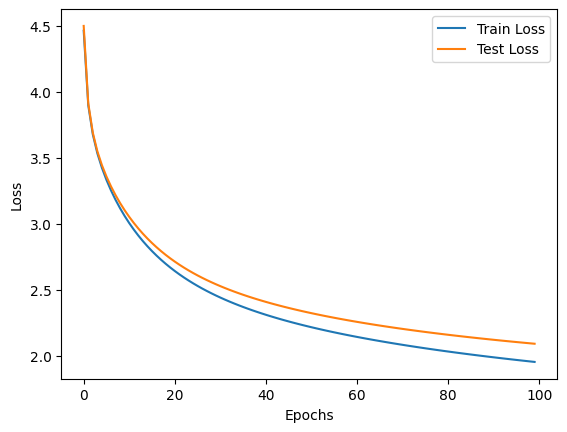

Test Loss:  2.0838884780551528
Test Accuracy:  0.2625


In [34]:
experiment_MLP(ex8,MLP_EXPERIMENT_LOSS_0LAYER)

# CNN EXPERIMENTS

## 2 Convolution, 2 Hidden layer

In [13]:
activation = ["sigmoid","relu"]
hidden_size = [[256,128],[128,64],[64,32]]
kernel_num = [2]
learning_rate = [0.01,0.001]
batch_size = [32,16]
epoch = 50


ex1 = [activation[0],hidden_size[0],learning_rate[1],batch_size[0],epoch,kernel_num]
ex2 = [activation[0],hidden_size[0],learning_rate[1],batch_size[1],epoch,kernel_num]
ex3 = [activation[0],hidden_size[0],learning_rate[0],batch_size[0],epoch,kernel_num]
ex4 = [activation[0],hidden_size[0],learning_rate[0],batch_size[1],epoch,kernel_num]
ex5 = [activation[0],hidden_size[1],learning_rate[1],batch_size[0],epoch,kernel_num]
ex6 = [activation[0],hidden_size[1],learning_rate[1],batch_size[1],epoch,kernel_num]
ex7 = [activation[0],hidden_size[1],learning_rate[0],batch_size[0],epoch,kernel_num]
ex8 = [activation[0],hidden_size[1],learning_rate[0],batch_size[1],epoch,kernel_num]
ex9 = [activation[0],hidden_size[2],learning_rate[1],batch_size[0],epoch,kernel_num]
ex10 = [activation[0],hidden_size[2],learning_rate[1],batch_size[1],epoch,kernel_num]
ex11 = [activation[0],hidden_size[2],learning_rate[0],batch_size[0],epoch,kernel_num]
ex12 = [activation[0],hidden_size[2],learning_rate[0],batch_size[1],epoch,kernel_num]
ex13 = [activation[1],hidden_size[0],learning_rate[1],batch_size[0],epoch,kernel_num]
ex14 = [activation[1],hidden_size[0],learning_rate[1],batch_size[1],epoch,kernel_num]
ex15 = [activation[1],hidden_size[0],learning_rate[0],batch_size[0],epoch,kernel_num]
ex16 = [activation[1],hidden_size[0],learning_rate[0],batch_size[1],epoch,kernel_num]
ex17 = [activation[1],hidden_size[1],learning_rate[1],batch_size[0],epoch,kernel_num]
ex18 = [activation[1],hidden_size[1],learning_rate[1],batch_size[1],epoch,kernel_num]
ex19 = [activation[1],hidden_size[1],learning_rate[0],batch_size[0],epoch,kernel_num]
ex20 = [activation[1],hidden_size[1],learning_rate[0],batch_size[1],epoch,kernel_num]
ex21 = [activation[1],hidden_size[2],learning_rate[1],batch_size[0],epoch,kernel_num]
ex22 = [activation[1],hidden_size[2],learning_rate[1],batch_size[1],epoch,kernel_num]
ex23 = [activation[1],hidden_size[2],learning_rate[0],batch_size[0],epoch,kernel_num]
ex24 = [activation[1],hidden_size[2],learning_rate[0],batch_size[1],epoch,kernel_num]



c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 0/50 loss: 1.8018076419830322
Epoch 10/50 loss: 1.638565182685852
Epoch 20/50 loss: 1.4829061031341553
Epoch 30/50 loss: 1.4722806215286255
Epoch 40/50 loss: 1.404057264328003


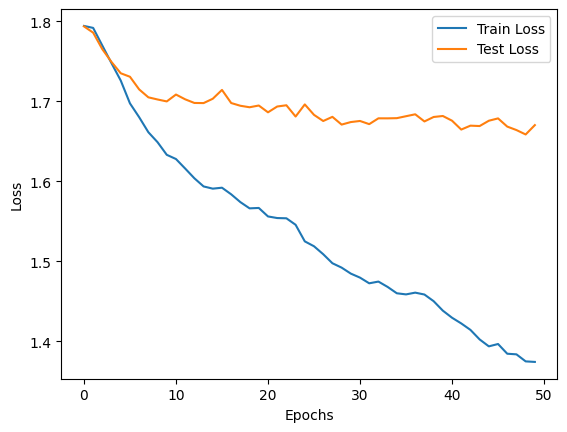

Accuracy:  0.3616666666666667


In [63]:

experiment_CNN(ex1)

c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 0/50 loss: 1.7908834218978882
Epoch 10/50 loss: 1.6938116550445557
Epoch 20/50 loss: 1.5806678533554077
Epoch 30/50 loss: 1.5362038612365723
Epoch 40/50 loss: 1.519069790840149


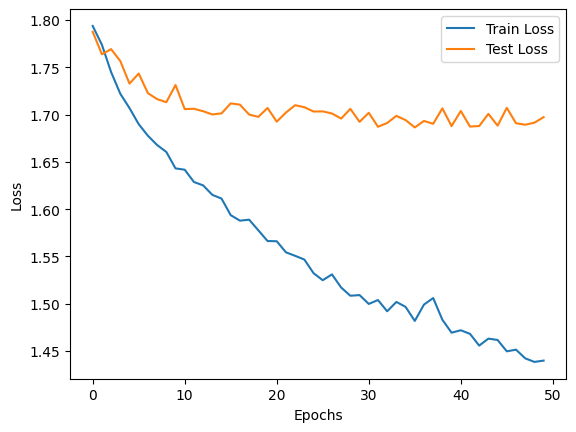

Accuracy:  0.32875


In [14]:

experiment_CNN(ex2)

Epoch 0/50 loss: 1.816842794418335
Epoch 10/50 loss: 1.7952795028686523
Epoch 20/50 loss: 1.7921092510223389
Epoch 30/50 loss: 1.789905309677124
Epoch 40/50 loss: 1.7894948720932007


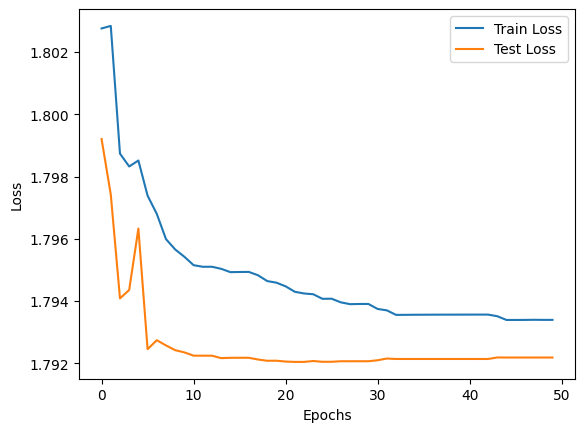

Accuracy:  0.16666666666666666


In [15]:

experiment_CNN(ex3)

Epoch 0/50 loss: 1.801550269126892
Epoch 10/50 loss: 1.7952603101730347
Epoch 20/50 loss: 1.7921764850616455
Epoch 30/50 loss: 1.7883952856063843
Epoch 40/50 loss: 1.788013219833374


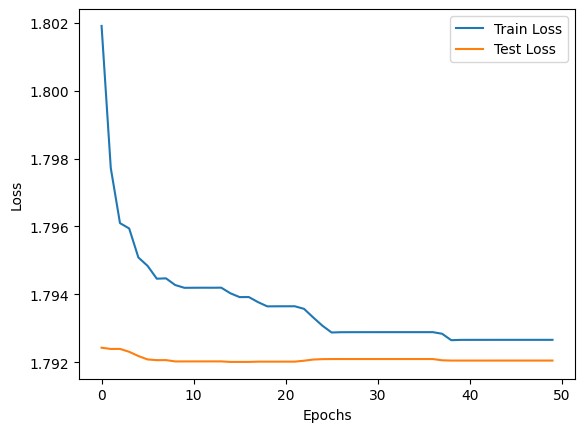

Accuracy:  0.16666666666666666


In [16]:

experiment_CNN(ex4)

Epoch 0/50 loss: 1.7888374328613281
Epoch 10/50 loss: 1.6083850860595703
Epoch 20/50 loss: 1.5611956119537354
Epoch 30/50 loss: 1.5117933750152588
Epoch 40/50 loss: 1.5152920484542847


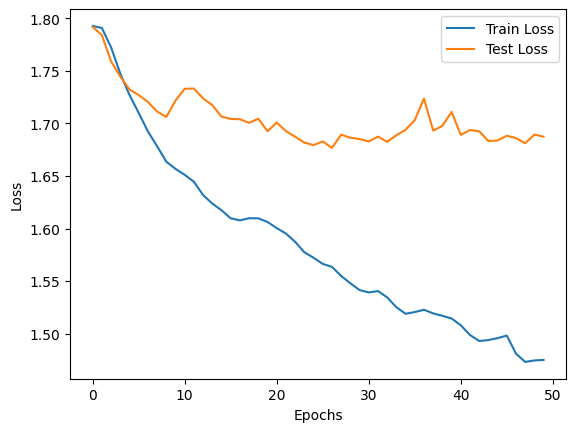

Accuracy:  0.33958333333333335


In [17]:

experiment_CNN(ex5)

Epoch 0/50 loss: 1.7621476650238037
Epoch 10/50 loss: 1.4691146612167358
Epoch 20/50 loss: 1.310275912284851
Epoch 30/50 loss: 1.3302544355392456
Epoch 40/50 loss: 1.1724014282226562


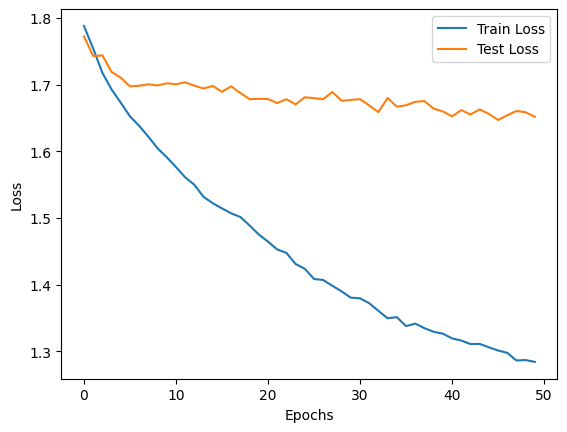

Accuracy:  0.3804166666666667


In [18]:

experiment_CNN(ex6)

Epoch 0/50 loss: 1.792881965637207
Epoch 10/50 loss: 1.791025161743164
Epoch 20/50 loss: 1.7910243272781372
Epoch 30/50 loss: 1.791024923324585
Epoch 40/50 loss: 1.7910252809524536


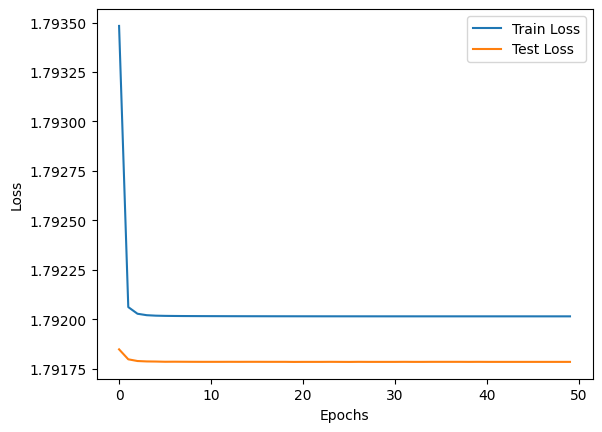

Accuracy:  0.16666666666666666


In [19]:

experiment_CNN(ex7)

Epoch 0/50 loss: 1.7885842323303223
Epoch 10/50 loss: 1.7899682521820068
Epoch 20/50 loss: 1.789969801902771
Epoch 30/50 loss: 1.78997004032135
Epoch 40/50 loss: 1.78997004032135


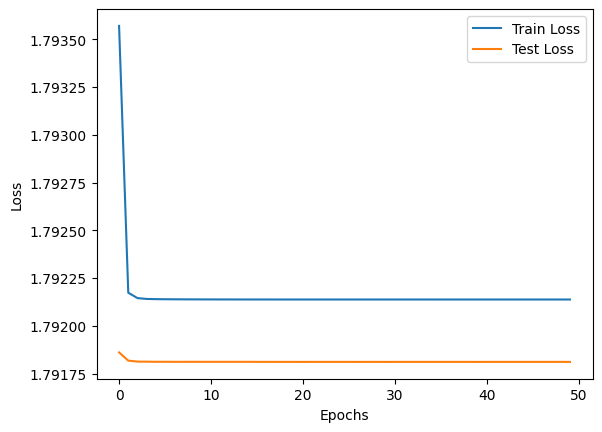

Accuracy:  0.16666666666666666


In [20]:

experiment_CNN(ex8)

Epoch 0/50 loss: 1.7921278476715088
Epoch 10/50 loss: 1.6394941806793213
Epoch 20/50 loss: 1.56815505027771
Epoch 30/50 loss: 1.4531058073043823
Epoch 40/50 loss: 1.384433388710022


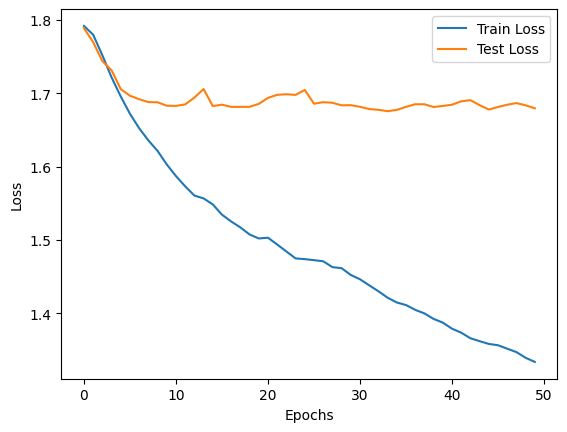

Accuracy:  0.35


In [21]:

experiment_CNN(ex9)

Epoch 0/50 loss: 1.7886050939559937
Epoch 10/50 loss: 1.7698509693145752
Epoch 20/50 loss: 1.6616605520248413
Epoch 30/50 loss: 1.532952070236206
Epoch 40/50 loss: 1.4676605463027954


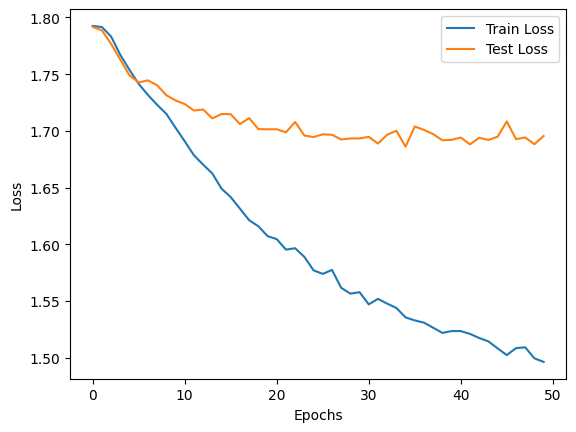

Accuracy:  0.33


In [22]:

experiment_CNN(ex10)

Epoch 0/50 loss: 1.7908827066421509
Epoch 10/50 loss: 1.7910159826278687
Epoch 20/50 loss: 1.7910232543945312
Epoch 30/50 loss: 1.7910246849060059
Epoch 40/50 loss: 1.791024923324585


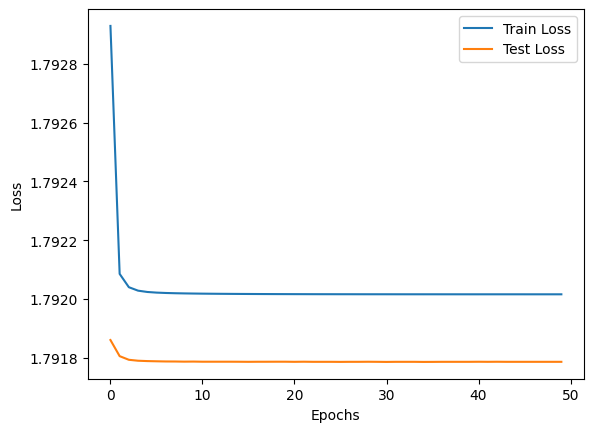

Accuracy:  0.16666666666666666


In [23]:

experiment_CNN(ex11)

Epoch 0/50 loss: 1.7882455587387085
Epoch 10/50 loss: 1.7899657487869263
Epoch 20/50 loss: 1.7899699211120605
Epoch 30/50 loss: 1.78997004032135
Epoch 40/50 loss: 1.7899701595306396


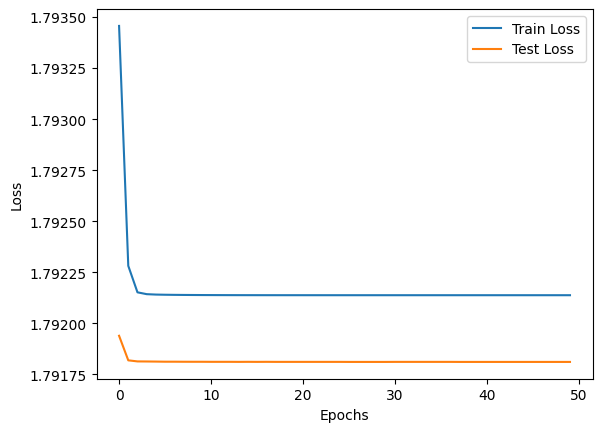

Accuracy:  0.16666666666666666


In [24]:

experiment_CNN(ex12)

Epoch 0/50 loss: 1.824841856956482
Epoch 10/50 loss: 1.824841856956482
Epoch 20/50 loss: 1.824841856956482
Epoch 30/50 loss: 1.824841856956482
Epoch 40/50 loss: 1.824841856956482


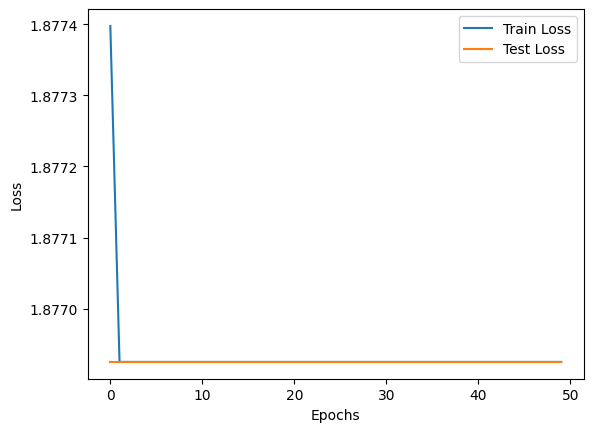

Accuracy:  0.16666666666666666


In [25]:

experiment_CNN(ex13)

Epoch 0/50 loss: 1.8560919761657715
Epoch 10/50 loss: 1.8560919761657715
Epoch 20/50 loss: 1.8560919761657715
Epoch 30/50 loss: 1.8560919761657715
Epoch 40/50 loss: 1.8560919761657715


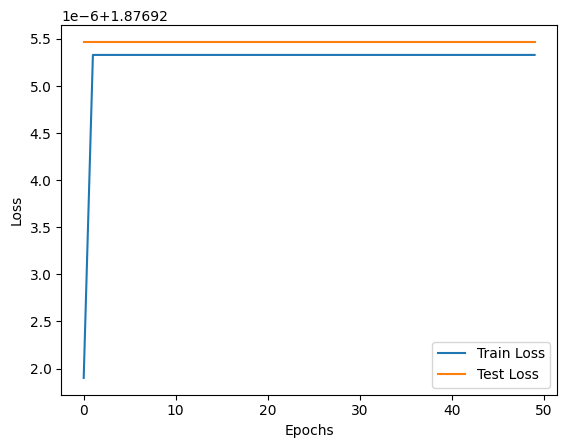

Accuracy:  0.16666666666666666


In [26]:

experiment_CNN(ex14)

Epoch 0/50 loss: 1.824841856956482
Epoch 10/50 loss: 1.824841856956482
Epoch 20/50 loss: 1.824841856956482
Epoch 30/50 loss: 1.824841856956482
Epoch 40/50 loss: 1.824841856956482


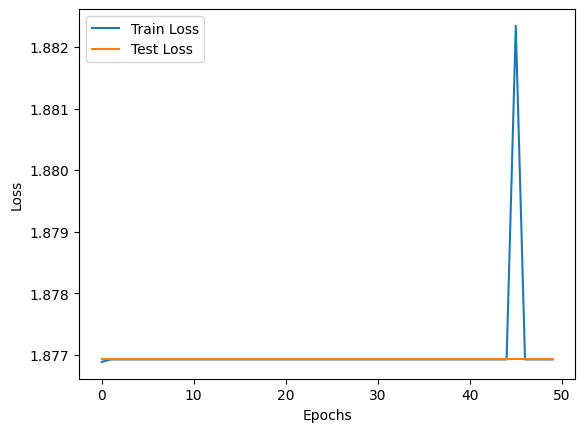

Accuracy:  0.16666666666666666


In [27]:

experiment_CNN(ex15)

Epoch 0/50 loss: 1.7935919761657715
Epoch 10/50 loss: 1.7935919761657715
Epoch 20/50 loss: 1.7935919761657715
Epoch 30/50 loss: 1.8560919761657715
Epoch 40/50 loss: 1.8560919761657715


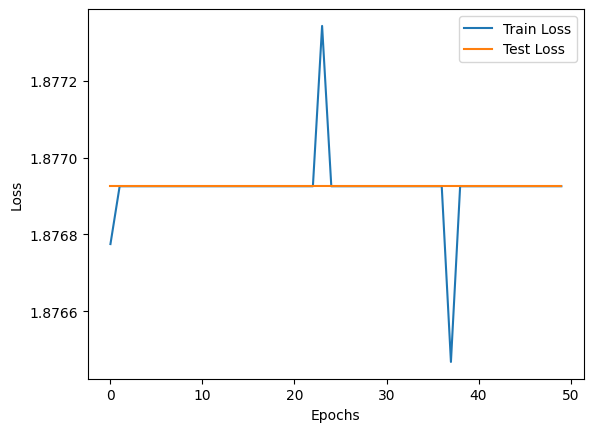

Accuracy:  0.16666666666666666


In [28]:

experiment_CNN(ex16)

Epoch 0/50 loss: 1.824841856956482
Epoch 10/50 loss: 1.824841856956482
Epoch 20/50 loss: 1.824841856956482
Epoch 30/50 loss: 1.824841856956482
Epoch 40/50 loss: 1.824841856956482


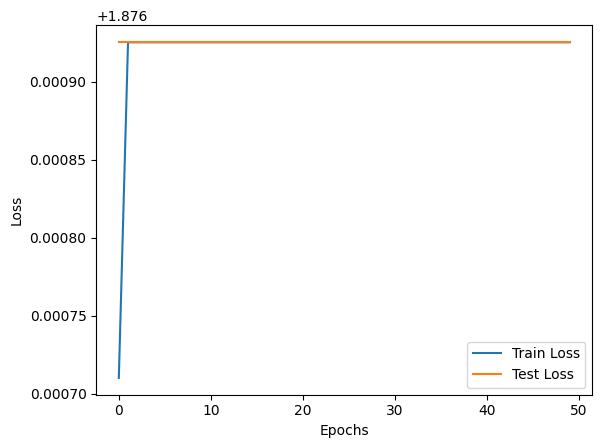

Accuracy:  0.16666666666666666


In [29]:

experiment_CNN(ex17)

Epoch 0/50 loss: 1.981092095375061
Epoch 10/50 loss: 1.981092095375061
Epoch 20/50 loss: 1.981092095375061
Epoch 30/50 loss: 1.981092095375061
Epoch 40/50 loss: 1.981092095375061


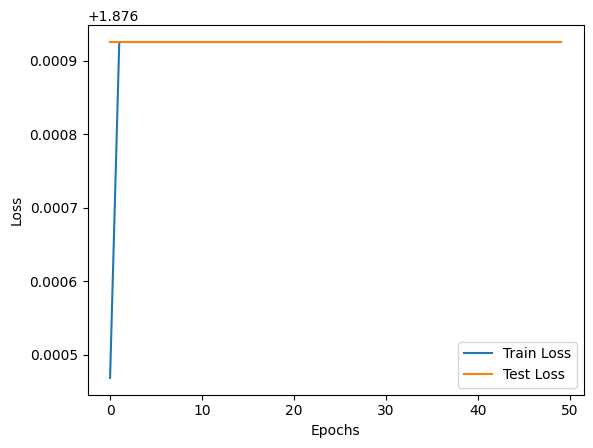

Accuracy:  0.16666666666666666


In [30]:

experiment_CNN(ex18)

Epoch 0/50 loss: 1.824841856956482
Epoch 10/50 loss: 1.824841856956482
Epoch 20/50 loss: 1.824841856956482
Epoch 30/50 loss: 1.824841856956482
Epoch 40/50 loss: 1.824841856956482


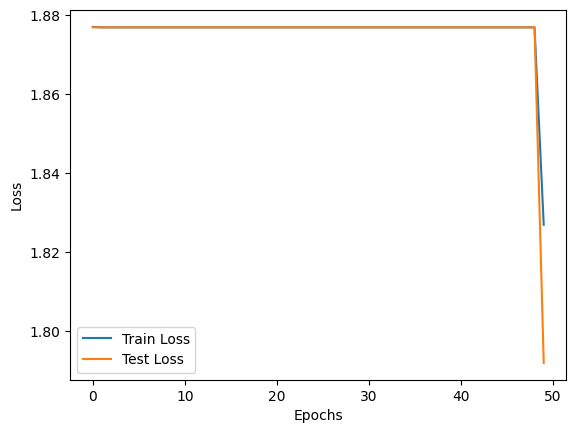

Accuracy:  0.16666666666666666


In [31]:

experiment_CNN(ex19)

Epoch 0/50 loss: 1.7935919761657715
Epoch 10/50 loss: 1.7935919761657715
Epoch 20/50 loss: 1.8560919761657715
Epoch 30/50 loss: 1.8560919761657715
Epoch 40/50 loss: 1.7899576425552368


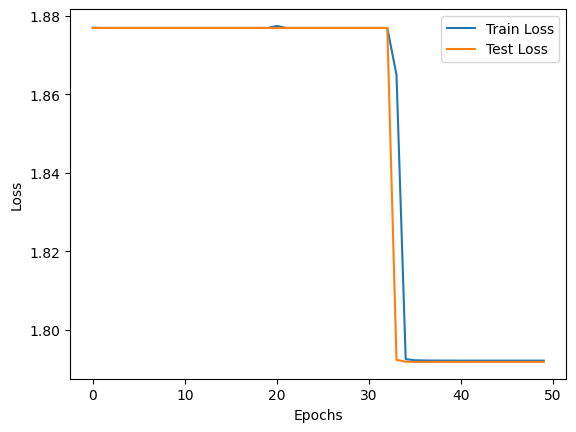

Accuracy:  0.16666666666666666


In [32]:

experiment_CNN(ex20)

Epoch 0/50 loss: 1.824841856956482
Epoch 10/50 loss: 1.824841856956482
Epoch 20/50 loss: 1.824841856956482
Epoch 30/50 loss: 1.824841856956482
Epoch 40/50 loss: 1.824841856956482


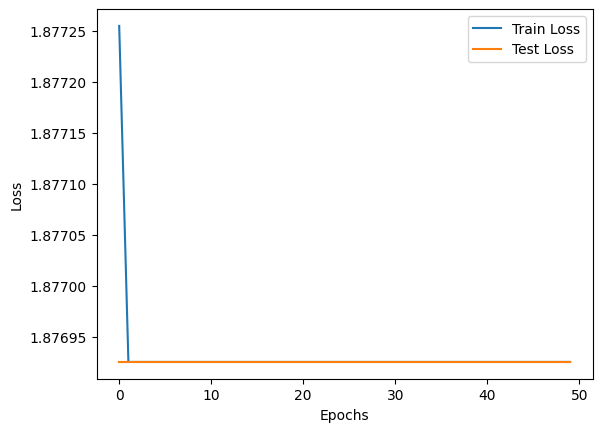

Accuracy:  0.16666666666666666


In [33]:

experiment_CNN(ex21)

Epoch 0/50 loss: 1.8560919761657715
Epoch 10/50 loss: 1.8560919761657715
Epoch 20/50 loss: 1.8560919761657715
Epoch 30/50 loss: 1.8560919761657715
Epoch 40/50 loss: 1.8560919761657715


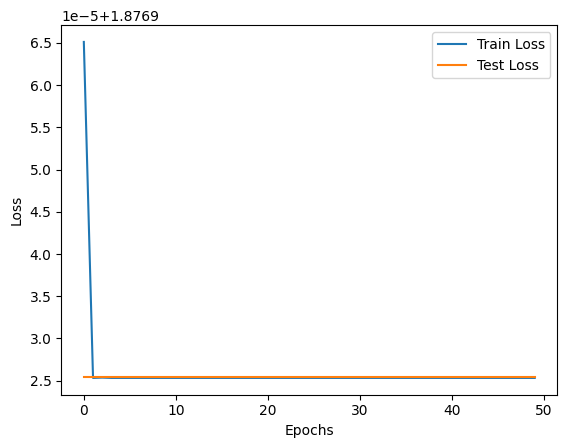

Accuracy:  0.16666666666666666


In [34]:

experiment_CNN(ex22)

Epoch 0/50 loss: 1.824841856956482
Epoch 10/50 loss: 1.824841856956482
Epoch 20/50 loss: 1.824841856956482
Epoch 30/50 loss: 1.824841856956482
Epoch 40/50 loss: 1.824841856956482


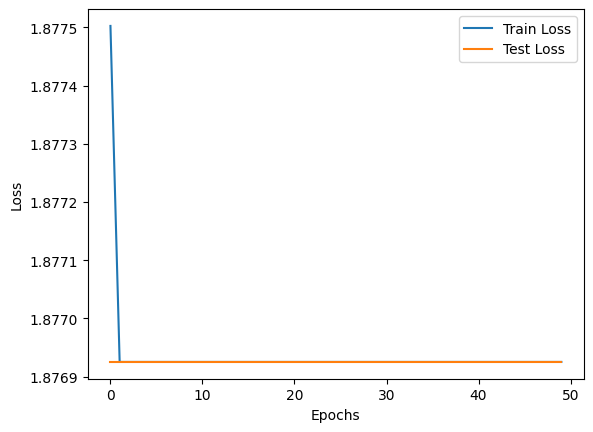

Accuracy:  0.16666666666666666


In [35]:

experiment_CNN(ex23)

Epoch 0/50 loss: 1.8560919761657715
Epoch 10/50 loss: 1.8560919761657715
Epoch 20/50 loss: 1.8560919761657715
Epoch 30/50 loss: 1.8560919761657715
Epoch 40/50 loss: 1.8560919761657715


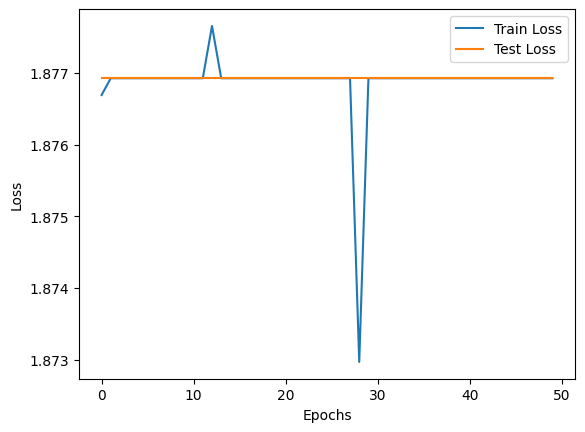

Accuracy:  0.16666666666666666


In [36]:

experiment_CNN(ex24)

## 1 Convolution, 1 Hidden Layer

In [53]:
activation = ["sigmoid","relu"]
hidden_size = [[256],[128],[64],[32],[16]]
kernel_num = [1]
learning_rate = [0.001,0.0001]
batch_size = [32,16]
epoch = 100


ex1 = [activation[0],hidden_size[0],learning_rate[1],batch_size[0],epoch,kernel_num]
ex2 = [activation[0],hidden_size[0],learning_rate[1],batch_size[1],epoch,kernel_num]
ex3 = [activation[0],hidden_size[1],learning_rate[0],batch_size[0],epoch,kernel_num]
ex4 = [activation[0],hidden_size[1],learning_rate[0],batch_size[1],epoch,kernel_num]
ex5 = [activation[0],hidden_size[2],learning_rate[1],batch_size[0],epoch,kernel_num]
ex6 = [activation[1],hidden_size[2],learning_rate[1],batch_size[1],epoch,kernel_num]
ex7 = [activation[1],hidden_size[3],learning_rate[0],batch_size[0],epoch,kernel_num]
ex8 = [activation[1],hidden_size[3],learning_rate[0],batch_size[1],epoch,kernel_num]
ex9 = [activation[1],hidden_size[4],learning_rate[1],batch_size[0],epoch,kernel_num]
ex10 = [activation[1],hidden_size[4],learning_rate[1],batch_size[1],epoch,kernel_num]


Epoch 0/100 loss: 1.787457823753357
Epoch 10/100 loss: 1.6872135400772095
Epoch 20/100 loss: 1.6436104774475098
Epoch 30/100 loss: 1.6280970573425293
Epoch 40/100 loss: 1.6039860248565674
Epoch 50/100 loss: 1.5754613876342773
Epoch 60/100 loss: 1.5446295738220215
Epoch 70/100 loss: 1.5015928745269775
Epoch 80/100 loss: 1.4635730981826782
Epoch 90/100 loss: 1.4407387971878052


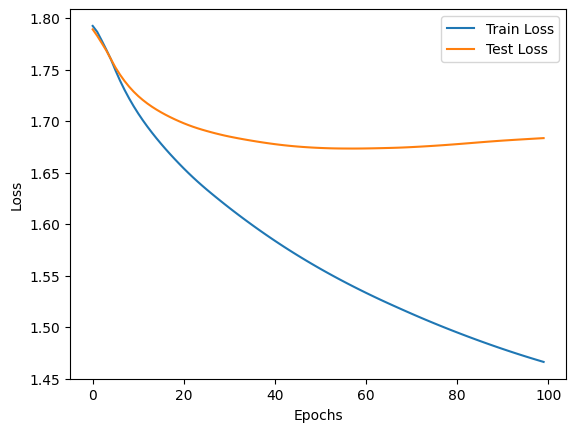

Accuracy:  0.33791666666666664


In [54]:
experiment_CNN(ex1)

Epoch 0/100 loss: 1.7818719148635864
Epoch 10/100 loss: 1.620870590209961
Epoch 20/100 loss: 1.5414108037948608
Epoch 30/100 loss: 1.481494426727295
Epoch 40/100 loss: 1.4571754932403564
Epoch 50/100 loss: 1.4491217136383057
Epoch 60/100 loss: 1.4462192058563232
Epoch 70/100 loss: 1.4444677829742432
Epoch 80/100 loss: 1.4323593378067017
Epoch 90/100 loss: 1.4313768148422241


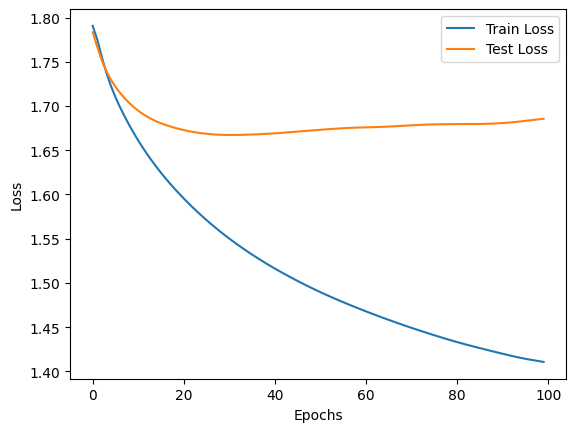

Accuracy:  0.33875


In [55]:
experiment_CNN(ex2)

Epoch 0/100 loss: 1.7872180938720703
Epoch 10/100 loss: 1.647839069366455
Epoch 20/100 loss: 1.539315938949585
Epoch 30/100 loss: 1.6089853048324585
Epoch 40/100 loss: 1.5076889991760254
Epoch 50/100 loss: 1.4596866369247437
Epoch 60/100 loss: 1.5177408456802368
Epoch 70/100 loss: 1.4779112339019775
Epoch 80/100 loss: 1.4115068912506104
Epoch 90/100 loss: 1.3839211463928223


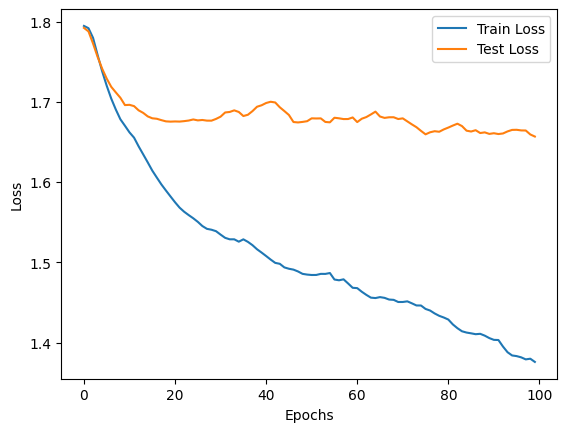

Accuracy:  0.3695833333333333


In [56]:
experiment_CNN(ex3)

Epoch 0/100 loss: 1.7925090789794922
Epoch 10/100 loss: 1.6110581159591675
Epoch 20/100 loss: 1.5051023960113525
Epoch 30/100 loss: 1.4197286367416382
Epoch 40/100 loss: 1.391015887260437
Epoch 50/100 loss: 1.3581291437149048
Epoch 60/100 loss: 1.179625153541565
Epoch 70/100 loss: 1.1697030067443848
Epoch 80/100 loss: 1.158725619316101
Epoch 90/100 loss: 1.1111608743667603


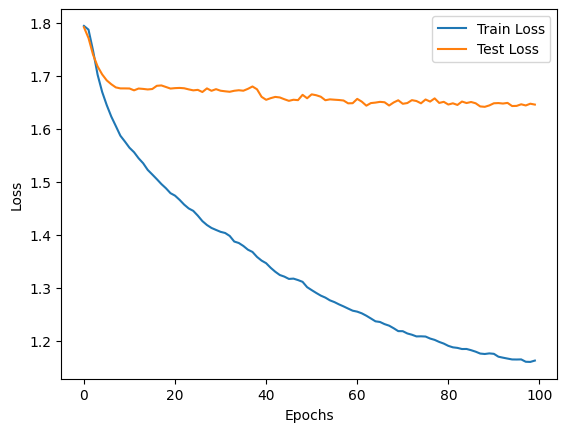

Accuracy:  0.3829166666666667


In [57]:
experiment_CNN(ex4)

Epoch 0/100 loss: 1.7873117923736572
Epoch 10/100 loss: 1.7233365774154663
Epoch 20/100 loss: 1.6690071821212769
Epoch 30/100 loss: 1.6333775520324707
Epoch 40/100 loss: 1.612252950668335
Epoch 50/100 loss: 1.5949143171310425
Epoch 60/100 loss: 1.5786972045898438
Epoch 70/100 loss: 1.5623317956924438
Epoch 80/100 loss: 1.5440552234649658
Epoch 90/100 loss: 1.5235410928726196


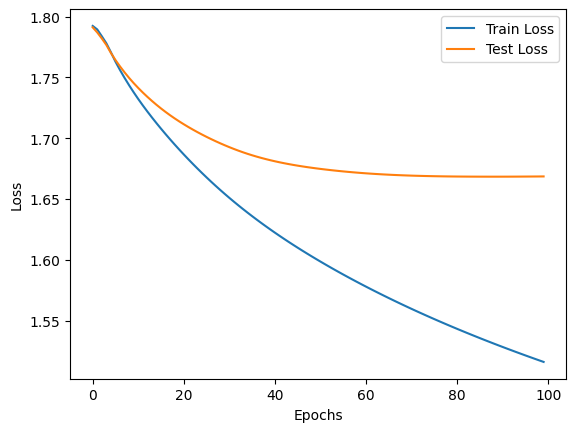

Accuracy:  0.35625


In [58]:
experiment_CNN(ex5)

Epoch 0/100 loss: 1.981092095375061
Epoch 10/100 loss: 1.981092095375061
Epoch 20/100 loss: 1.981092095375061
Epoch 30/100 loss: 1.981092095375061
Epoch 40/100 loss: 1.981092095375061
Epoch 50/100 loss: 1.981092095375061
Epoch 60/100 loss: 1.981092095375061
Epoch 70/100 loss: 1.981092095375061
Epoch 80/100 loss: 1.981092095375061
Epoch 90/100 loss: 1.981092095375061


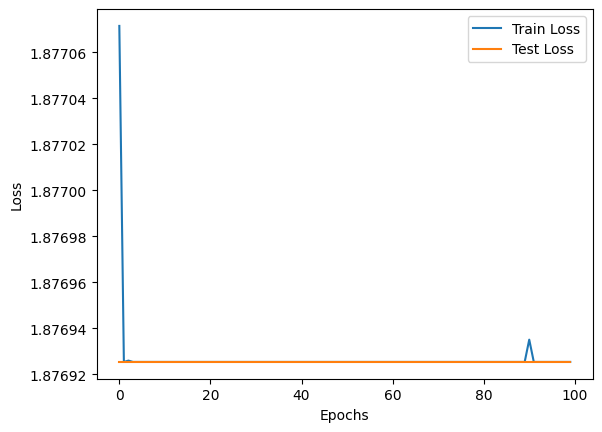

Accuracy:  0.16666666666666666


In [59]:
experiment_CNN(ex6)

Epoch 0/100 loss: 1.9498419761657715
Epoch 10/100 loss: 1.9498419761657715
Epoch 20/100 loss: 1.9498419761657715
Epoch 30/100 loss: 1.9498419761657715
Epoch 40/100 loss: 1.9498419761657715
Epoch 50/100 loss: 1.9498419761657715
Epoch 60/100 loss: 1.9498419761657715
Epoch 70/100 loss: 1.9498419761657715
Epoch 80/100 loss: 1.9498419761657715
Epoch 90/100 loss: 1.9498419761657715


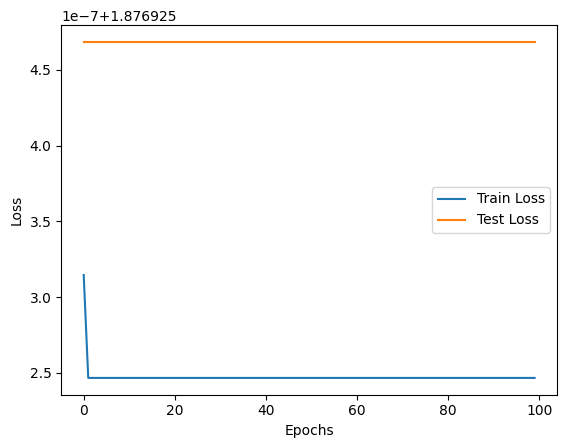

Accuracy:  0.16666666666666666


In [60]:
experiment_CNN(ex7)

Epoch 0/100 loss: 1.981092095375061
Epoch 10/100 loss: 1.981092095375061
Epoch 20/100 loss: 1.981092095375061
Epoch 30/100 loss: 1.981092095375061
Epoch 40/100 loss: 1.8560919761657715
Epoch 50/100 loss: 1.8560919761657715
Epoch 60/100 loss: 1.8560919761657715
Epoch 70/100 loss: 1.8560919761657715
Epoch 80/100 loss: 1.8560919761657715
Epoch 90/100 loss: 1.8560919761657715


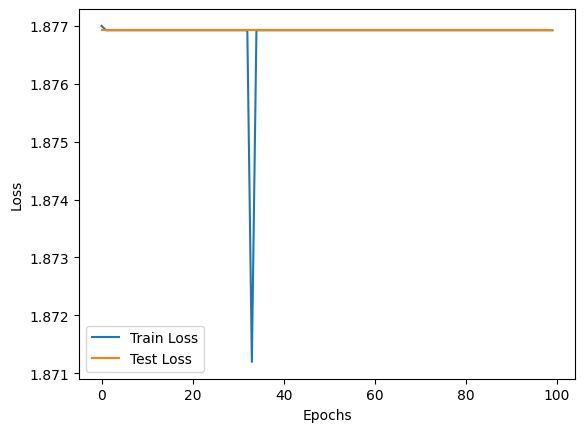

Accuracy:  0.16666666666666666


In [61]:
experiment_CNN(ex8)

Epoch 0/100 loss: 1.824841856956482
Epoch 10/100 loss: 1.824841856956482
Epoch 20/100 loss: 1.824841856956482
Epoch 30/100 loss: 1.9498419761657715
Epoch 40/100 loss: 1.9498419761657715
Epoch 50/100 loss: 1.9498419761657715
Epoch 60/100 loss: 1.9498419761657715
Epoch 70/100 loss: 1.9498419761657715
Epoch 80/100 loss: 1.9498419761657715
Epoch 90/100 loss: 1.9498419761657715


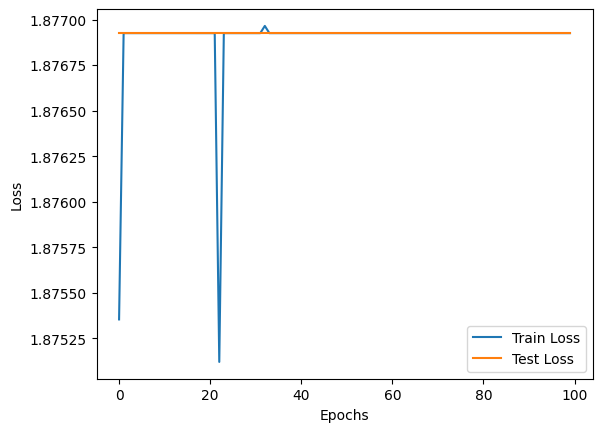

Accuracy:  0.16666666666666666


In [62]:
experiment_CNN(ex9)

Epoch 0/100 loss: 1.7935919761657715
Epoch 10/100 loss: 1.981092095375061
Epoch 20/100 loss: 1.981092095375061
Epoch 30/100 loss: 1.981092095375061
Epoch 40/100 loss: 1.981092095375061
Epoch 50/100 loss: 1.981092095375061
Epoch 60/100 loss: 1.981092095375061
Epoch 70/100 loss: 1.771712064743042
Epoch 80/100 loss: 1.7653603553771973
Epoch 90/100 loss: 1.7425106763839722


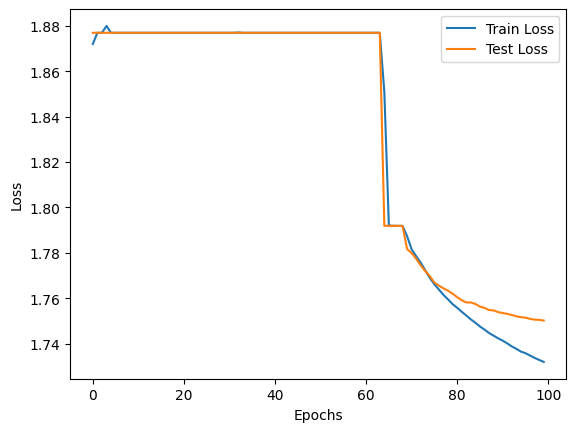

Accuracy:  0.24958333333333332


In [63]:
experiment_CNN(ex10)